In [1]:
import config
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from IPython.display import display
import json
import datetime
import math

from utils.data_exploration_utils import kruskal_wallis_analysis, barplots
from utils.hdbscan_utils import plot_hdbscan, plot_hdbscan_highlight_kl, make_cluster_color_map
from utils.plot_utils import plotly_hdbscan_highlight_kl

/home/czuppinger/miniconda3/envs/mtenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026-01-12 15:08:06.271025: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-12 15:08:06.362867: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-12 15:08:08.606379: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see sli

In [2]:
STAGE = 'ss'
MOD_PREFIX = "mod_smallimg3"
NEPOCH = 'latest'


DATAPATH = config.OUTPUT_PATH
base_dir = config.RAW_DATA_PATH
img_path = config.SCHULTHESS_DATAPATH
proc_dir = config.PROC_DATA_PATH

feature = 'rawq'
folder = "2025-11-19_hdbscan"
run = "run10"  
mapping_list = [0, 4, 2, -1, 1]
# order = [0, 4, 2, 1]
# order_wnoise = [0,4,2,-1,1]

anomalyscore_metric = "centre_mean"
cluster_col = "cluster_label"

In [3]:
rating = {
    '1': 's+',
    '2': 's',
    '4': 'm',
    '0': 'h',
    '-1': 'noise'
}

rating_order = {
    'h': 0,
    'm': 1,
    's': 2,
    's+': 3,
    'noise': -1
}

## Load HDBSCAN Data

In [4]:
today = datetime.date.today()
folder_date = folder.split('_')[0]

filepath = os.path.join(proc_dir, folder, "pipeline", run)
save_path = os.path.join(filepath, "img")
os.makedirs(save_path, exist_ok=True)

# try:
#     hdbscan_df = pd.read_csv(os.path.join(filepath, f'pipeline_{run}_umap_hdbscan_scaled_allpoints_wKL.csv'))
# except:
hdbscan_df = pd.read_csv(os.path.join(filepath, f'pipeline_{run}_umap_hdbscan_scaled.csv'))
#.merge(kl_df, left_on = 'id', right_on='name', how='left', validate='one_to_one')
kl = pd.read_csv(os.path.join(proc_dir, "2025-08-11_data_exploration", "inmodi_data_questionnaire_kl_woSC.csv"))
hdbscan_df = hdbscan_df.merge(kl, left_on = 'id', right_on='name', how='left', validate='one_to_one')

with open(os.path.join(filepath, f'pipeline_{run}_umap_hdbscan_scaled_model_info.json')) as f:
    model_info= json.load(f)

In [6]:
folder_df = "2025-09-11_data_exploration"
df_filename = "inmodi_data_questionnaire_kl_woSC.csv"
df = pd.read_csv(os.path.join(proc_dir, folder_df, df_filename))
df2 = hdbscan_df[hdbscan_df['id'].isin(df['name'])]

df2['old_cluster'] = df2['cluster_label']
df2['cluster_label_name'] = df2['cluster_label'].astype(str).map(rating)
df2['cluster_label']=df2['cluster_label_name'].map(rating_order)

/tmp/ipykernel_384291/3015483207.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['old_cluster'] = df2['cluster_label']
/tmp/ipykernel_384291/3015483207.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['cluster_label_name'] = df2['cluster_label'].astype(str).map(rating)
/tmp/ipykernel_384291/3015483207.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [7]:
ids = model_info['files']['ids']

In [8]:
print(len(ids))

370


In [9]:
print(len(df2))

356


In [10]:
hdbscan_df = df2

In [11]:
# hdbscan_df = pd.read_csv(os.path.join(filepath, f'pipeline_{run}_umap_hdbscan_scaled.csv'))
hdbscan_df['cluster_label'].value_counts()

cluster_label
 0    308
 1     24
 3     18
 2      3
-1      3
Name: count, dtype: int64

## Load Embeddings

In [13]:
embeddings_path = os.path.join(filepath, "X_umap_embeddings.npy")
X_umap = np.load(embeddings_path)


In [14]:
X_umap.shape

(370, 3)

## Load MRI Data

In [7]:
mri = pd.read_csv(os.path.join(base_dir, '2025-09-25_mrismall.csv'))

## Load SS-FewSome Results

In [8]:
outputs = os.path.join(DATAPATH, 'outputs', 'dfs', STAGE)

filepath2 =  []
for file in os.listdir(outputs):
    if MOD_PREFIX in file and str(NEPOCH) in file and '_all' in file:
        filepath2.append(os.path.join(outputs, file))
dfs = []
for path in filepath2:
    df = pd.read_csv(path)[['id', anomalyscore_metric]]  # only keep id + target col
    dfs.append(df.rename(columns={anomalyscore_metric: os.path.basename(path)})) 
combined = dfs[0]
for df in dfs[1:]:
    combined = pd.merge(combined, df, on='id', how="inner")  # 'inner' keeps only common IDs

experiment_cols = [c for c in combined.columns if c != 'id']
combined["mean"] = combined[experiment_cols].mean(axis=1)
combined["std"] = combined[experiment_cols].std(axis=1)
combined.to_csv(os.path.join(outputs, f"{MOD_PREFIX}_{STAGE}_aggregated_scores.csv"), index = False)
combined['filepath'] = combined['id']
combined['id'] = combined['id'].apply(lambda x: x.split('/')[-1].replace('.png', ''))

In [9]:
print(len(mri))
print(len(combined))
print(len(hdbscan_df))

439
427
372


## Create Combined Data

In [10]:
print(len(combined), "samples in combined dataframe")
print(len(hdbscan_df), "samples in hdbscan dataframe")

427 samples in combined dataframe
372 samples in hdbscan dataframe


In [11]:
dfc = combined.merge(hdbscan_df, on='id', how = 'right')

In [12]:
print(len(dfc), "samples in combined dataframe")

372 samples in combined dataframe


In [13]:
dfc[dfc['mean'].isna()]

,id,ss_training_mod_smallimg3_bs_1_task_test_lr_0.0002_N_30_seed_193_latest.pt_all_all,ss_training_mod_smallimg3_bs_1_task_test_lr_0.0002_N_30_seed_1001_latest.pt_all_all,ss_training_mod_smallimg3_bs_1_task_test_lr_0.0002_N_30_seed_44_latest.pt_all_all,ss_training_mod_smallimg3_bs_1_task_test_lr_0.0002_N_30_seed_8765_latest.pt_all_all,ss_training_mod_smallimg3_bs_1_task_test_lr_0.0002_N_30_seed_244959_latest.pt_all_all,ss_training_mod_smallimg3_bs_1_task_test_lr_0.0002_N_30_seed_875688_latest.pt_all_all,ss_training_mod_smallimg3_bs_1_task_test_lr_0.0002_N_30_seed_71530_latest.pt_all_all,ss_training_mod_smallimg3_bs_1_task_test_lr_0.0002_N_30_seed_138647_latest.pt_all_all,ss_training_mod_smallimg3_bs_1_task_test_lr_0.0002_N_30_seed_985772_latest.pt_all_all,...,koos_a17,koos_sp1,koos_sp2,koos_sp3,koos_sp4,koos_sp5,koos_q1,koos_q2,koos_q3,koos_q4
77,IM2511_1_left,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,2.0,0.0,0.0,2.0,2.0,2.0,1.0,1.0
84,IM2569_1_left,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,2.0,2.0,3.0,3.0,2.0,3.0,2.0,3.0,3.0
92,IM3003_1_left,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,3.0,3.0,3.0,4.0,3.0,3.0,3.0,4.0,4.0
100,IM3020_1_left,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,4.0,4.0,4.0,4.0,1.0,3.0,4.0,4.0,4.0
136,IM1512_2_left,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,2.0,2.0,2.0,1.0,2.0,1.0,3.0,2.0,2.0
145,IM1567_2_left,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,2.0,2.0,3.0,0.0,0.0,1.0,1.0,1.0,1.0
147,IM1578_2_left,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,2.0,2.0,2.0,1.0,2.0,2.0,3.0,2.0,2.0
260,IM2511_1_right,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,2.0,0.0,0.0,2.0,2.0,2.0,1.0,1.0
266,IM2569_1_right,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,2.0,2.0,3.0,3.0,2.0,3.0,2.0,3.0,3.0
276,IM3003_1_right,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,3.0,3.0,3.0,4.0,3.0,3.0,3.0,4.0,4.0


In [14]:
dfc2 = mri.merge(dfc, on='id', how='left')

In [15]:
df = hdbscan_df.copy()

In [16]:
print(dfc2[dfc2['mri_cart_yn'].isna()])

Empty DataFrame
Columns: [record_id_x, redcap_event_name, mri_operator, mri_side, mri_bml_yn, mri_cart_yn, mri_osteo_yn, mri_syn_yn, mri_mnsc_yn, mri_lig_yn, visit_x, side_x, id, ss_training_mod_smallimg3_bs_1_task_test_lr_0.0002_N_30_seed_193_latest.pt_all_all, ss_training_mod_smallimg3_bs_1_task_test_lr_0.0002_N_30_seed_1001_latest.pt_all_all, ss_training_mod_smallimg3_bs_1_task_test_lr_0.0002_N_30_seed_44_latest.pt_all_all, ss_training_mod_smallimg3_bs_1_task_test_lr_0.0002_N_30_seed_8765_latest.pt_all_all, ss_training_mod_smallimg3_bs_1_task_test_lr_0.0002_N_30_seed_244959_latest.pt_all_all, ss_training_mod_smallimg3_bs_1_task_test_lr_0.0002_N_30_seed_875688_latest.pt_all_all, ss_training_mod_smallimg3_bs_1_task_test_lr_0.0002_N_30_seed_71530_latest.pt_all_all, ss_training_mod_smallimg3_bs_1_task_test_lr_0.0002_N_30_seed_138647_latest.pt_all_all, ss_training_mod_smallimg3_bs_1_task_test_lr_0.0002_N_30_seed_985772_latest.pt_all_all, ss_training_mod_smallimg3_bs_1_task_test_lr_0.0002

In [17]:
dfc2.shape

(439, 103)

# Anomaly Score distribution

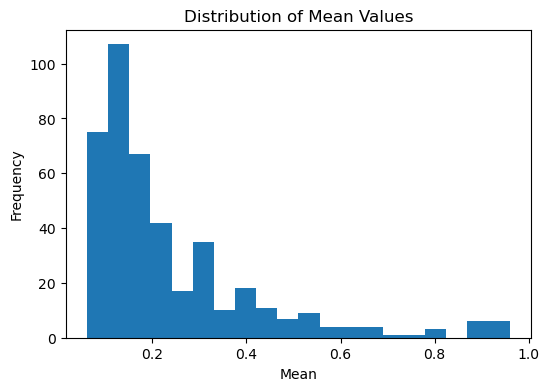

In [18]:
# comb2 = combined.iloc[:, :-3]

# Boxplot
plt.figure(figsize=(6, 4))
plt.hist(combined['mean'], bins=20)
plt.title('Distribution of Mean Values')
plt.xlabel('Mean')
plt.ylabel('Frequency')
plt.show()


In [19]:
hdbscan_df['cluster_label'].value_counts()

cluster_label
 0    316
 4     28
 1     20
 2      3
-1      3
 3      2
Name: count, dtype: int64

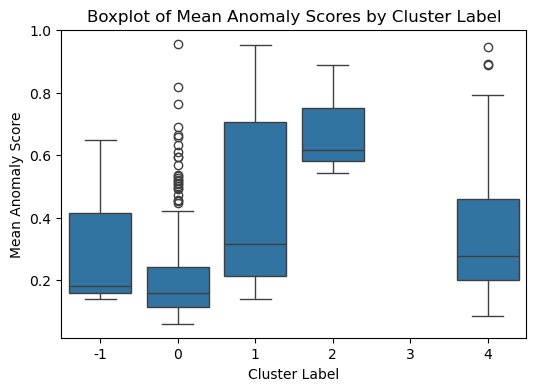

In [20]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='cluster_label', y='mean', data=dfc)
plt.title('Boxplot of Mean Anomaly Scores by Cluster Label')
plt.xlabel('Cluster Label') 
plt.ylabel('Mean Anomaly Score')
plt.show()

In [21]:
print(f"Min. Anomaly Score: {combined['mean'].min():.3f}")
print(f"Max. Anomaly Score: {combined['mean'].max():.3f}")

Min. Anomaly Score: 0.061
Max. Anomaly Score: 0.960


In [22]:
for cluster in df['cluster_label'].unique():
    cluster_data = dfc[dfc['cluster_label'] == cluster]['mean']
    print(f"Cluster {cluster}: n={len(cluster_data)}, mean={cluster_data.mean():.3f}, std={cluster_data.std():.3f}, min={cluster_data.min():.3f}, max={cluster_data.max():.3f}")

Cluster 0: n=316, mean=0.208, std=0.142, min=0.061, max=0.956
Cluster 4: n=28, mean=0.382, std=0.263, min=0.086, max=0.945
Cluster 1: n=20, mean=0.442, std=0.294, min=0.141, max=0.951
Cluster 3: n=2, mean=nan, std=nan, min=nan, max=nan
Cluster 2: n=3, mean=0.683, std=0.181, min=0.543, max=0.887
Cluster -1: n=3, mean=0.322, std=0.282, min=0.139, max=0.647


# Test Grouping of AS

In [23]:
# Create Groups of Anomaly Scores
def assign_as_group(mean_score):
    if mean_score < 0.3:
        return 'Low'
    elif 0.3 <= mean_score < 0.6:
        return 'Medium'
    else:
        return 'High'

In [24]:
mri_columns = [ 'mri_operator',
 'mri_side',
 'mri_bml_yn',
 'mri_cart_yn',
 'mri_osteo_yn',
 'mri_syn_yn',
 'mri_mnsc_yn',
 'mri_lig_yn']


In [25]:
# dfc2['AS_Group'] = dfc2['mean'].apply(assign_as_group)

# display(dfc2['AS_Group'].value_counts())

In [26]:
# dfc2_nonan = dfc2.dropna(subset=['AS_Group', 'cluster_label'])
# pd.crosstab(dfc2_nonan['AS_Group'], dfc2_nonan['cluster_label'], normalize='columns')

# Some Exploration

In [27]:
df['cluster_label'].value_counts().reset_index().sort_values('cluster_label')

,cluster_label,count
4,-1,3
0,0,316
2,1,20
3,2,3
5,3,2
1,4,28


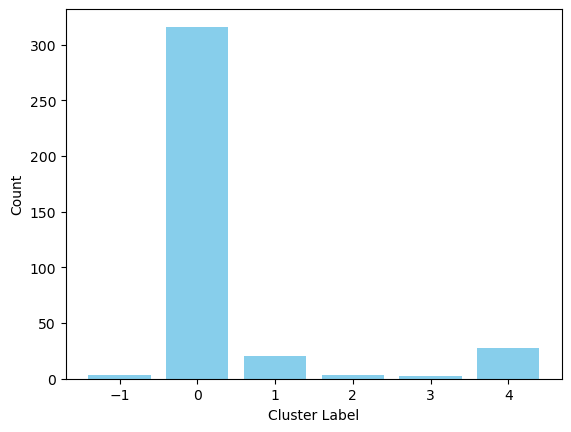

In [28]:
values = df['cluster_label'].value_counts().reset_index().sort_values(by='cluster_label')

plt.bar(values['cluster_label'], values['count'], color = 'skyblue')
plt.xlabel('Cluster Label')
plt.ylabel('Count')
plt.show()

## Feature Analysis Clusters

In [31]:
import math

/tmp/ipykernel_134778/3777506570.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_134778/3777506570.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_134778/3777506570.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_134778/3777506570.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


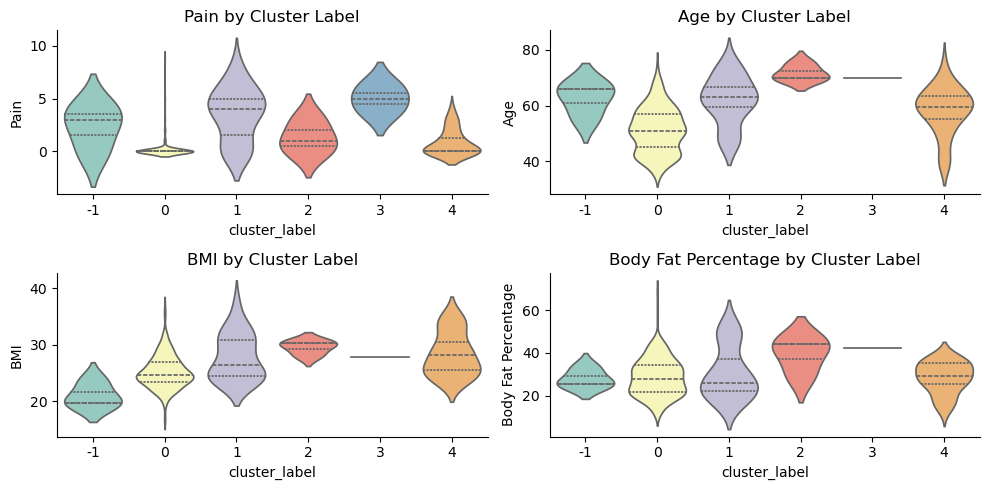

In [32]:
cols = ['pain', 'age', 'ce_bmi', 'ce_fm']
col_names = ['Pain', 'Age', 'BMI', 'Body Fat Percentage']

n = 2
rows = math.ceil(n / 2)

plt.figure(figsize=(5*n, 5))

for i, col in enumerate(cols, 1):
    rows = math.ceil(len(cols) / n)
    plt.subplot(rows, n, i)
    sns.violinplot(
        data=df,
        x='cluster_label',
        y=col,
        palette='Set3',
        inner='quartile'
    )
    plt.title(f'{col_names[i-1]} by Cluster Label')
    plt.xlabel('cluster_label')
    plt.ylabel(col_names[i-1])
    sns.despine()

plt.tight_layout()
plt.show()

/tmp/ipykernel_134778/1972497089.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_134778/1972497089.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_134778/1972497089.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_134778/1972497089.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_134778/1972497089.py:

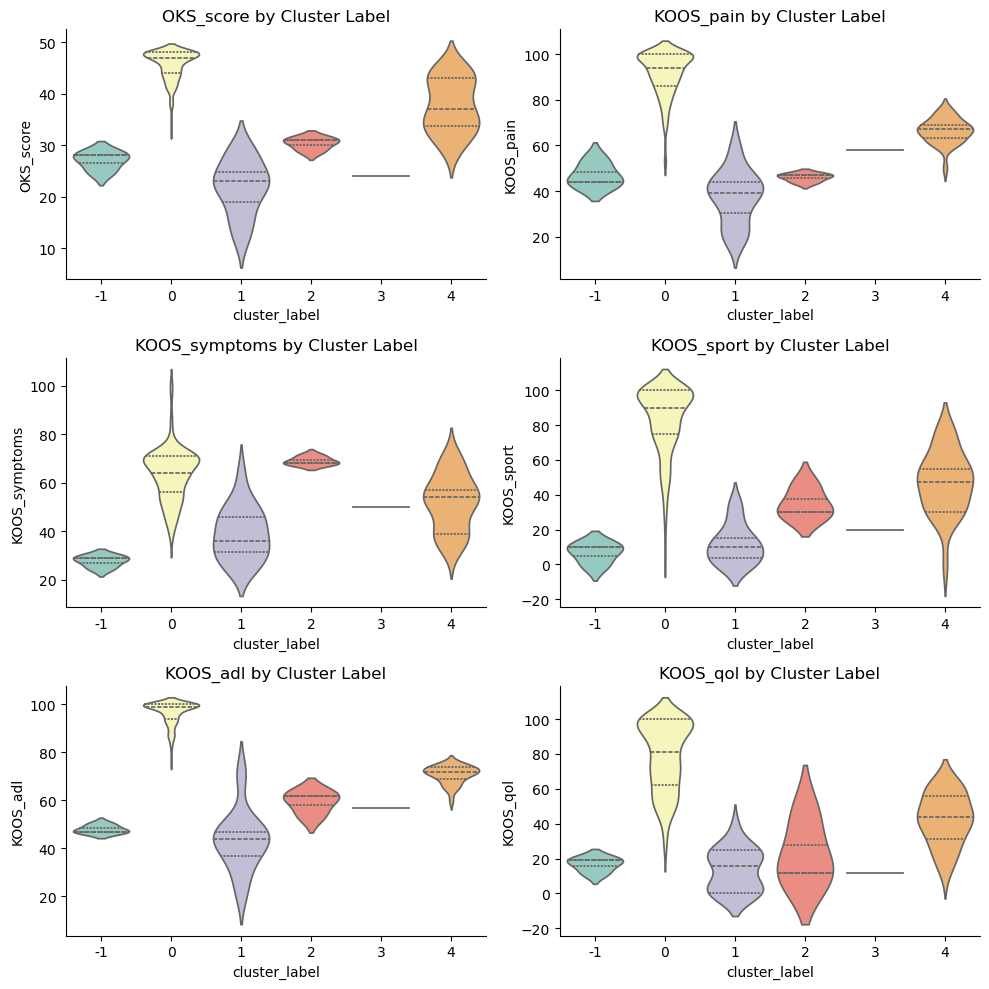

In [38]:
cols = ['OKS_score', 
       'KOOS_pain', 'KOOS_symptoms', 'KOOS_sport', 'KOOS_adl',
       'KOOS_qol']
n = 2
rows = math.ceil(n / 2)

plt.figure(figsize=(5*n, 10))

for i, col in enumerate(cols, 1):
    rows = math.ceil(len(cols) / n)
    plt.subplot(rows, n, i)
    sns.violinplot(
        data=df,
        x='cluster_label',
        y=col,
        palette='Set3',
        inner='quartile'
    )
    plt.title(f'{col} by Cluster Label')
    plt.xlabel('cluster_label')
    plt.ylabel(col)
    sns.despine()

plt.tight_layout()
plt.show()

In [35]:
df[df['cluster_label']==3]['ce_fm']

92     42.3
276    42.3
Name: ce_fm, dtype: float64

### Cluster Label vs KL-Score

<Figure size 2000x1000 with 0 Axes>

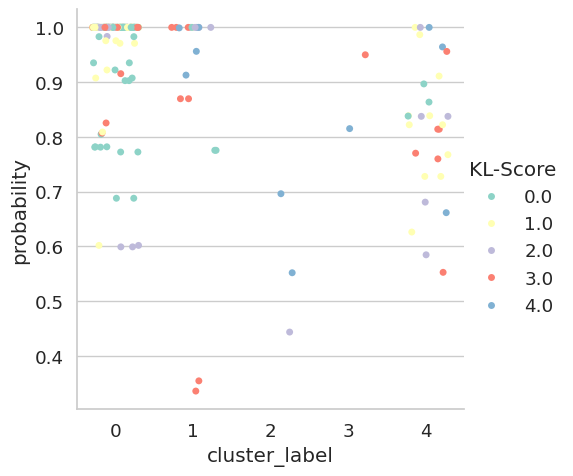

In [99]:
# scatterplot
color_map = make_cluster_color_map(df['KL-Score'].unique())
sns.set_theme(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(20, 10))
sns.catplot(data = df[df['cluster_label']!=-1], x='cluster_label', y='probability', hue='KL-Score', palette='Set3', jitter = 0.3)
plt.show()

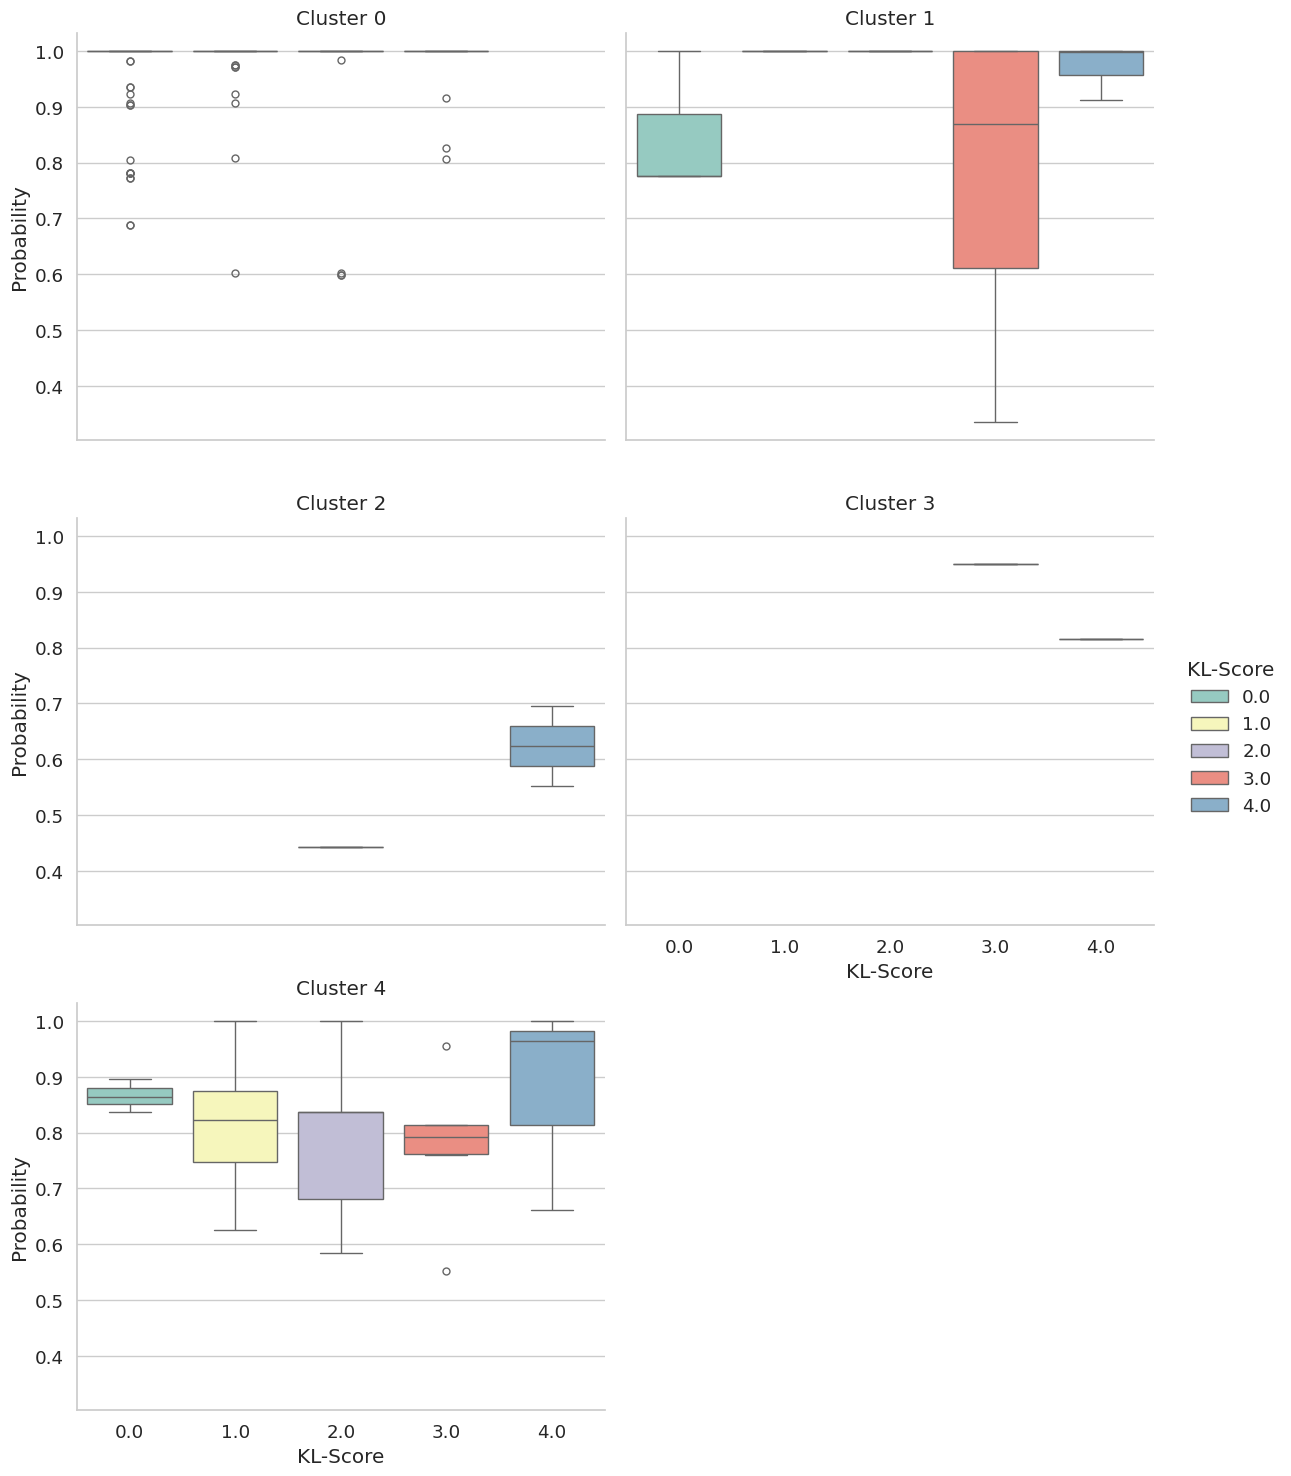

In [100]:
sns.set_theme(style="whitegrid", font_scale=1.2)

df2 = df[df['cluster_label'] != -1]

g = sns.catplot(
    data=df2,
    x='KL-Score',
    y='probability',
    hue='KL-Score',          # <- adds legend
    kind='box',
    col='cluster_label',
    col_wrap=2,
    palette='Set3',
    height=5,
    aspect=1.2,
)

g.set_titles("Cluster {col_name}")
g.set_axis_labels("KL-Score", "Probability")
g.tight_layout()
plt.show()



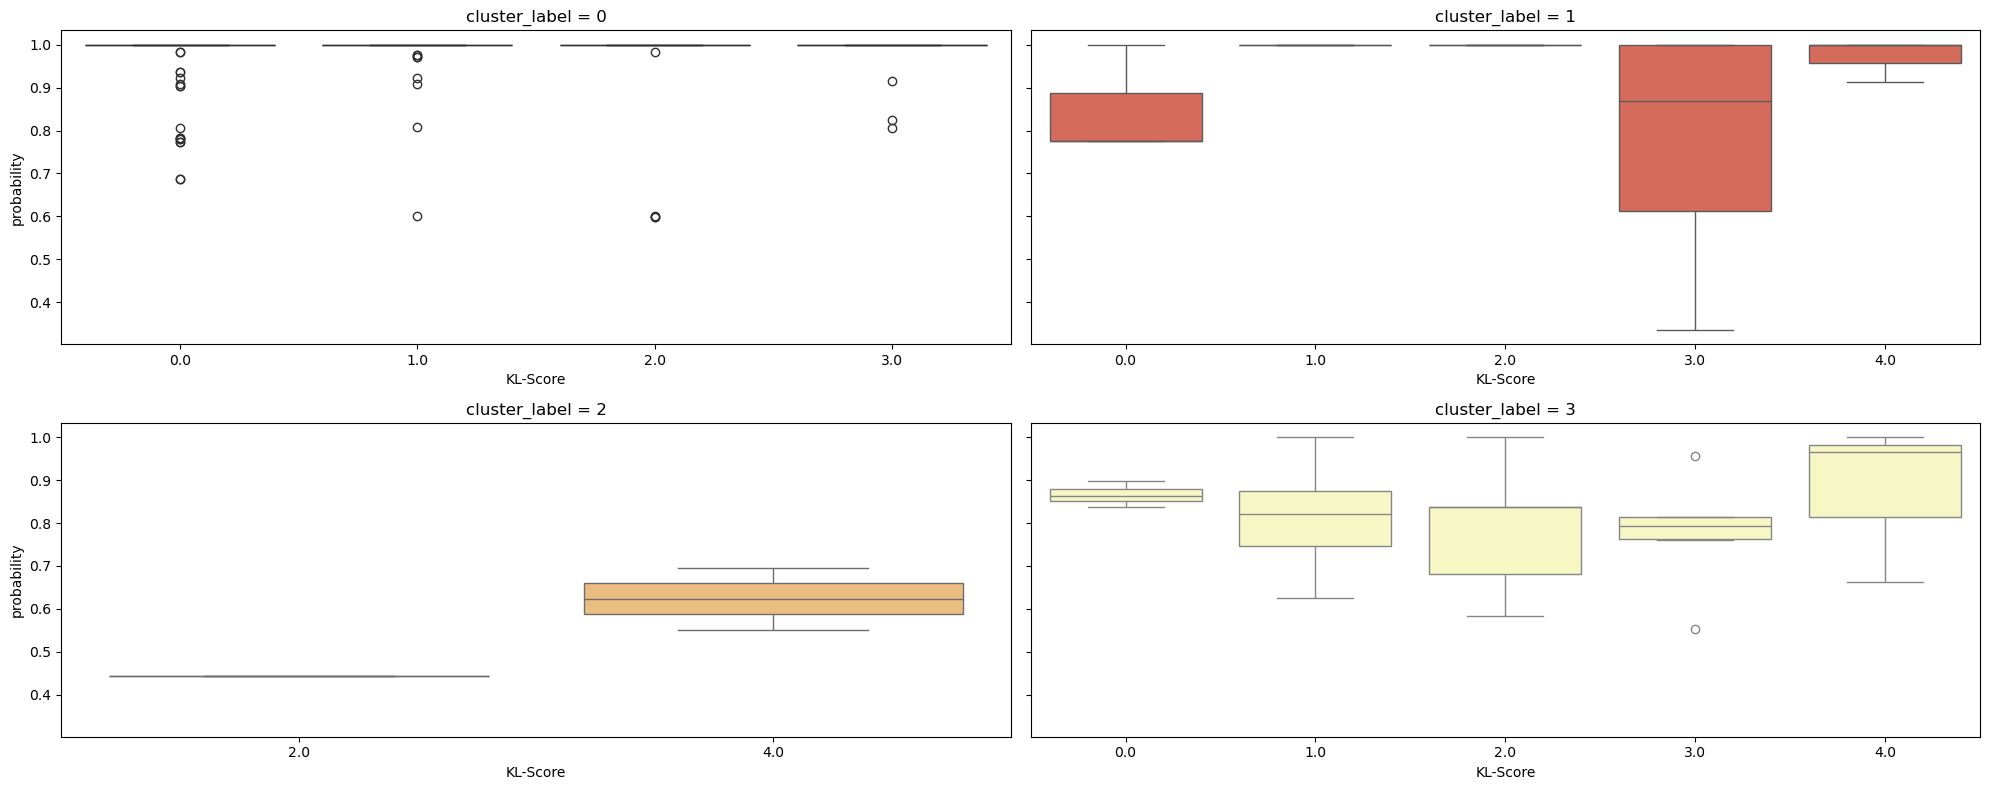

In [25]:
kls = sorted(df['cluster_label'].unique())
kls = [kl for kl in kls if kl != -1]  # exclude noise

ncols = 2
nrows = math.ceil(len(kls)/ncols)
fig, ax = plt.subplots(nrows, ncols, figsize=(20, 4*nrows), sharey=True)
ax = np.ravel(ax)  # flatten to 1D

for idx, kl in enumerate(kls):
    sns.boxplot(
        data=df[df['cluster_label'] == kl],
        x='KL-Score', y='probability',
        ax=ax[idx], color=color_map[kl]
    )
    ax[idx].set_title(f"cluster_label = {kl}")

# hide any unused axes
for j in range(len(kls), len(ax)):
    ax[j].set_visible(False)

plt.tight_layout()
plt.savefig(os.path.join(save_path, f'{folder}_{run}_probability_cluster_klscore_v2_rawq.png'))
plt.show()

In [102]:
df['cluster_label'].value_counts()

cluster_label
 0    316
 4     28
 1     20
 2      3
-1      3
 3      2
Name: count, dtype: int64

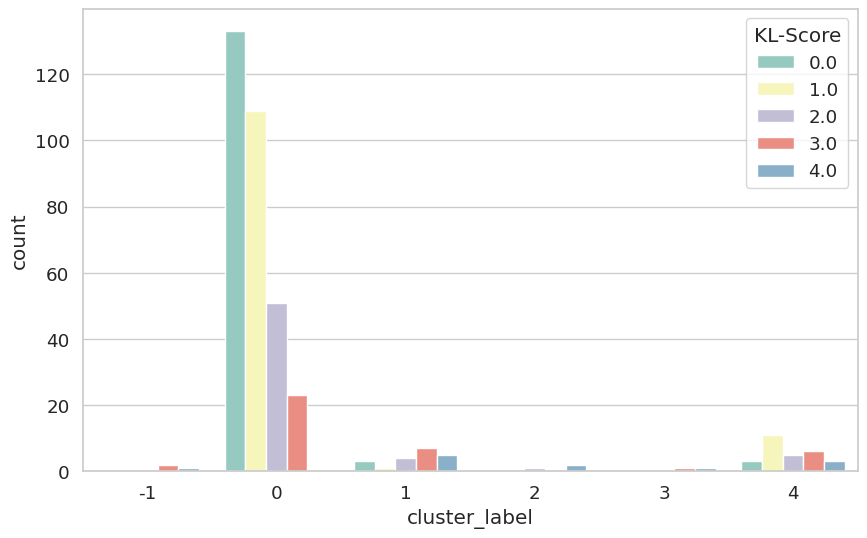

In [103]:
sns.set_theme(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(10, 6))
sns.countplot(
    data=df,
    x='cluster_label',
    hue='KL-Score',
    palette='Set3'
)
# sns.histplot(data=df, x='cluster_label', hue='KL-Score', multiple='dodge', palette='Set3')
plt.show()

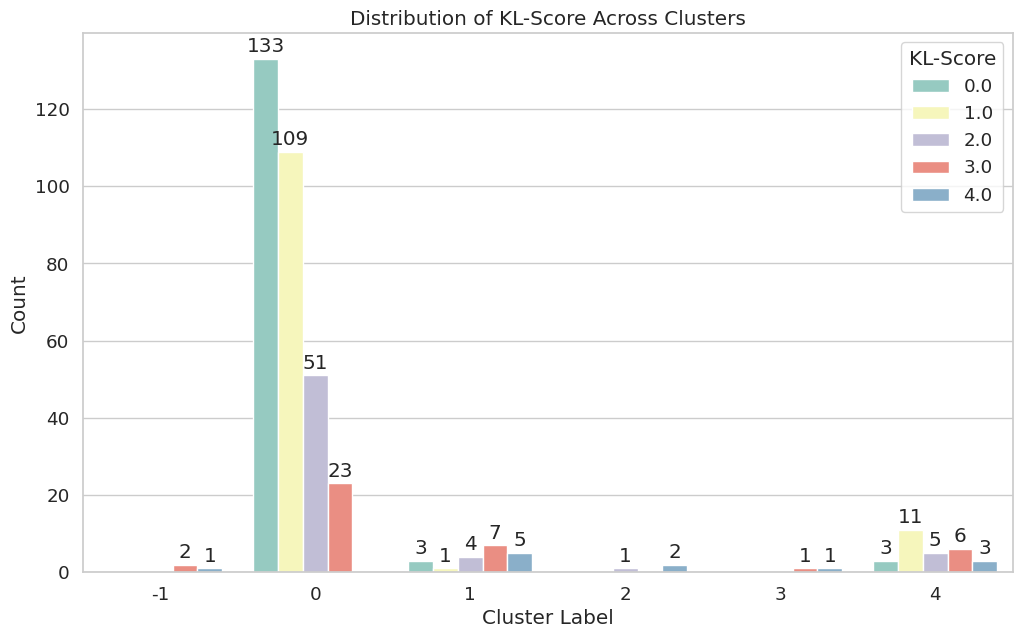

In [104]:
sns.set_theme(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(12, 7))

ax = sns.countplot(
    data=df,
    x='cluster_label',
    hue='KL-Score',
    palette='Set3'
)

# Add counts above bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=2)

plt.xlabel("Cluster Label")
plt.ylabel("Count")
plt.title("Distribution of KL-Score Across Clusters")

plt.show()

In [28]:
for cluster in df['cluster_label'].unique():
    cluster_data = dfc2[dfc2['cluster_label'] == cluster]
    print(f"Cluster {cluster} KL-Score Distribution:")
    display(cluster_data.value_counts('KL-Score').reset_index())

Cluster 0 KL-Score Distribution:


,KL-Score,count
0,0.0,132
1,1.0,107
2,2.0,51
3,3.0,22


Cluster 3 KL-Score Distribution:


,KL-Score,count
0,1.0,11
1,3.0,6
2,2.0,5
3,0.0,2
4,4.0,2


Cluster 1 KL-Score Distribution:


,KL-Score,count
0,3.0,7
1,4.0,5
2,2.0,4
3,0.0,3
4,1.0,1


Cluster 2 KL-Score Distribution:


,KL-Score,count
0,4.0,2
1,2.0,1


Cluster -1 KL-Score Distribution:


,KL-Score,count
0,3.0,2
1,4.0,1


## Cluster Label vs MRI Data

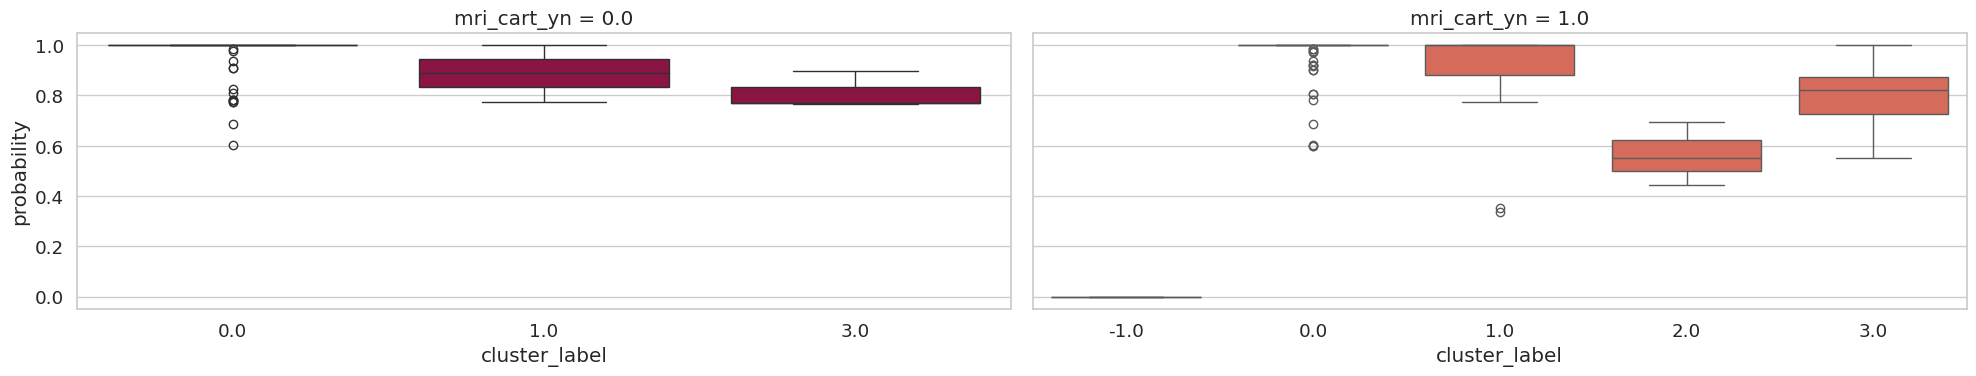

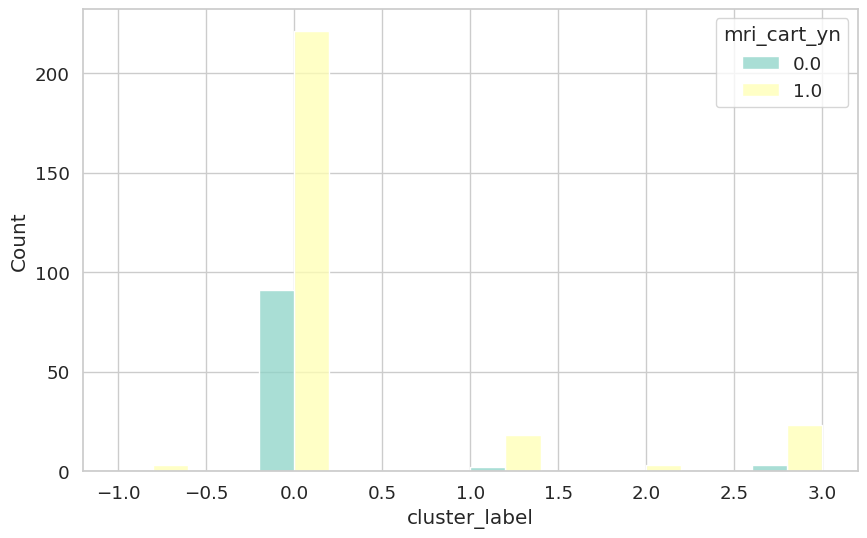

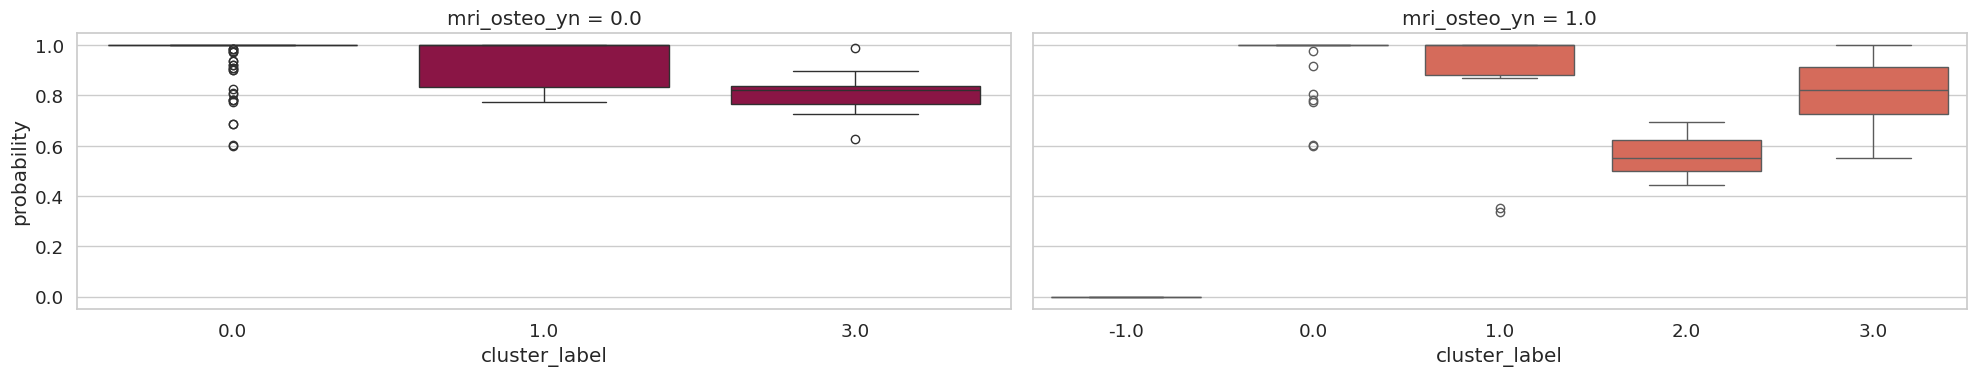

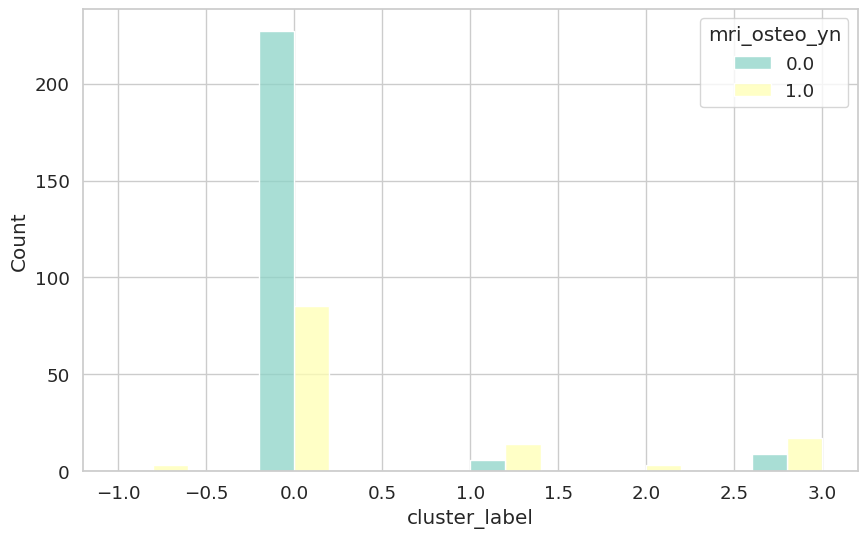

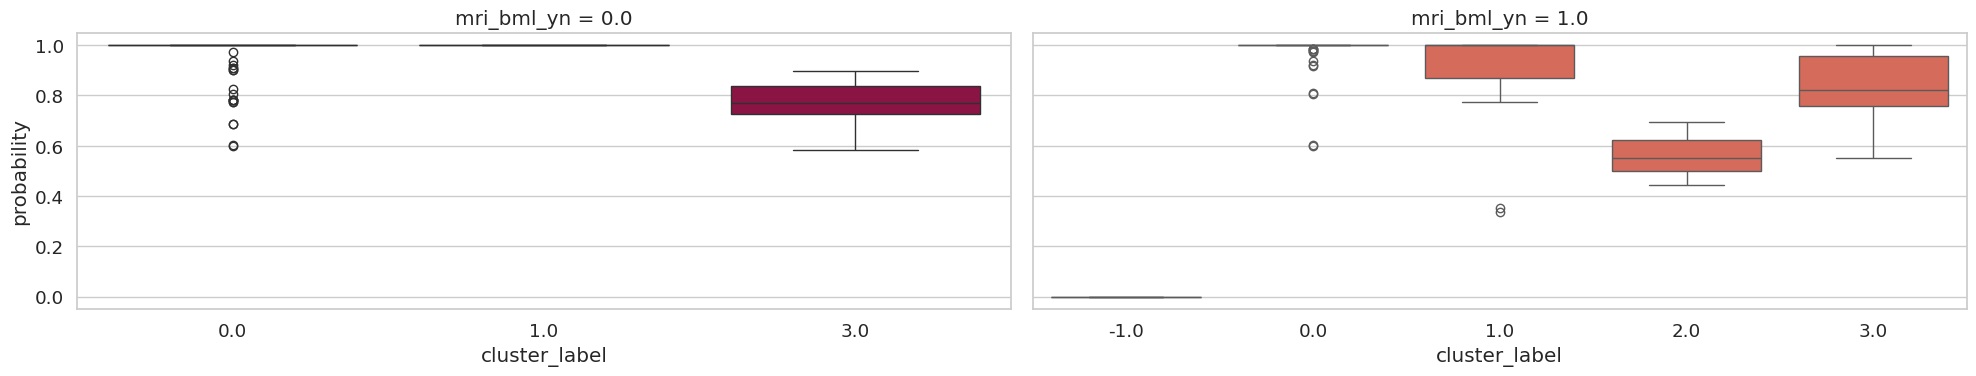

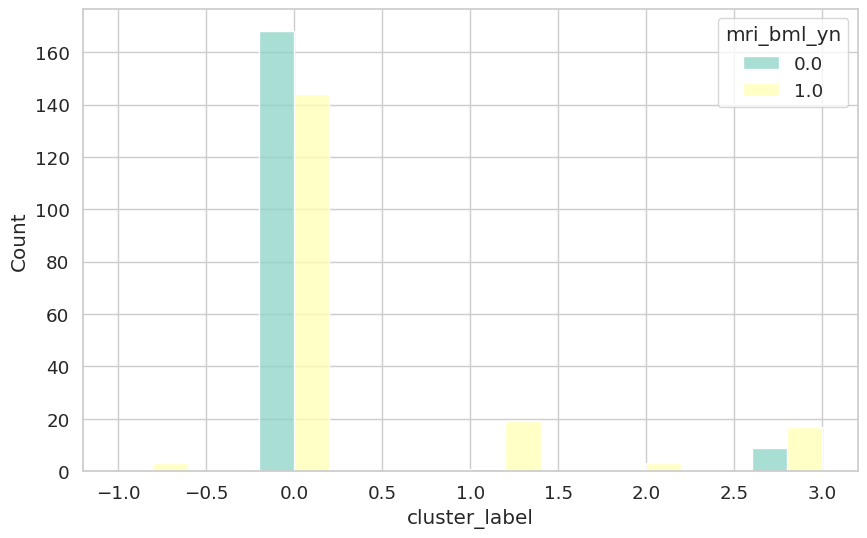

In [29]:
mri_cols = ['mri_cart_yn', 'mri_osteo_yn', 'mri_bml_yn']

for mri_col in mri_cols:
    kls = sorted(dfc2[mri_col].unique())

    ncols = 2
    nrows = math.ceil(len(kls)/ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize=(20, 4*nrows), sharey=True)
    ax = np.ravel(ax)  # flatten to 1D

    for idx, kl in enumerate(kls):
        sns.boxplot(
            data=dfc2[dfc2[mri_col] == kl],
            x='cluster_label', y='probability',
            ax=ax[idx], color=color_map[kl]
        )
        ax[idx].set_title(f"{mri_col} = {kl}")

    # hide any unused axes
    for j in range(len(kls), len(ax)):
        ax[j].set_visible(False)

    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f'{folder}_{run}_probability_cluster_{mri_col}_rawq.png'))
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.histplot(data=dfc2, x='cluster_label', hue=mri_col, multiple='dodge', palette='Set3')
    plt.savefig(os.path.join(save_path, f'{folder}_{run}_histogram_cluster_{mri_col}_rawq.png'))
    plt.show()

In [105]:
dfc2.shape

(439, 103)

In [106]:
summary = dfc2.groupby('cluster_label')[['mri_cart_yn', 'mri_osteo_yn', 'mri_bml_yn']].mean()

In [107]:
summary

,mri_cart_yn,mri_osteo_yn,mri_bml_yn
cluster_label,,,
-1.0,1.000000,1.000000,1.000000
0.0,0.708333,0.272436,0.461538
1.0,0.900000,0.700000,0.950000
2.0,1.000000,1.000000,1.000000
3.0,1.000000,0.500000,1.000000
4.0,0.884615,0.653846,0.653846


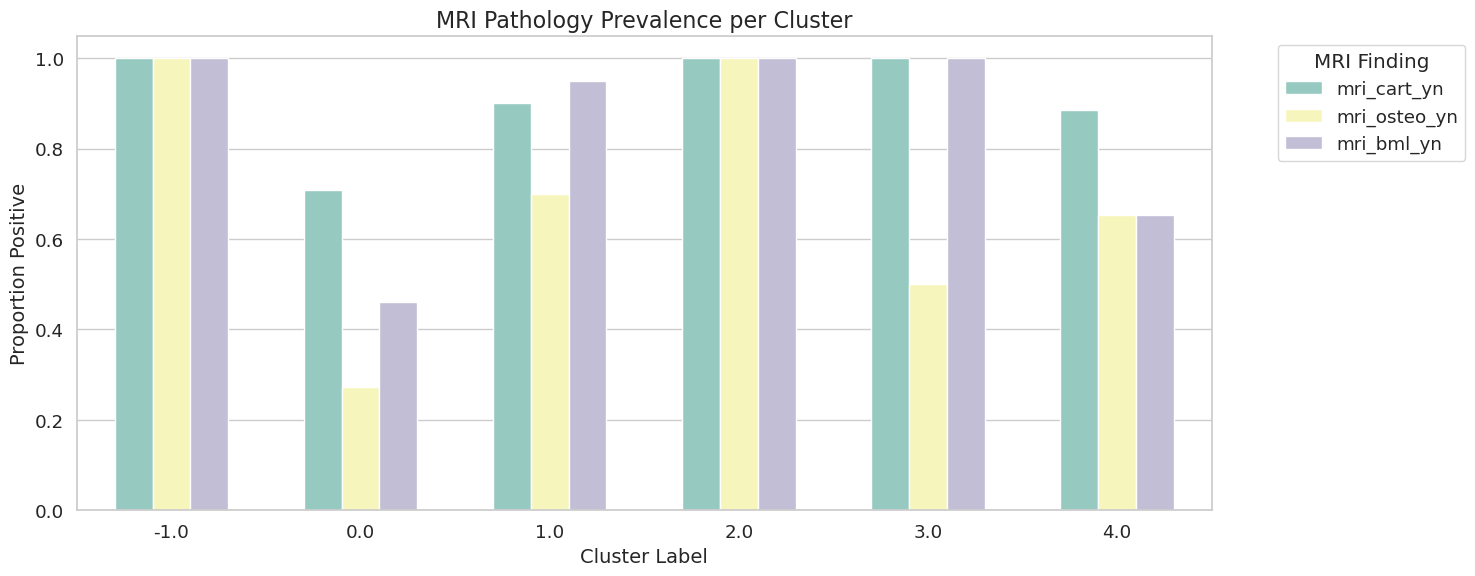

In [108]:
summary_long = summary.reset_index().melt(
    id_vars="cluster_label",
    value_vars=["mri_cart_yn", "mri_osteo_yn", "mri_bml_yn"],
    var_name="MRI_feature",
    value_name="proportion_positive"
)
sns.set_theme(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(15, 6))

sns.barplot(
    data=summary_long,
    x="cluster_label",
    y="proportion_positive",
    hue="MRI_feature",
    palette="Set3"
    , width=0.6
)

plt.xlabel("Cluster Label", fontsize=14)
plt.ylabel("Proportion Positive", fontsize=14)
plt.title("MRI Pathology Prevalence per Cluster", fontsize=16)
plt.legend(
    title="MRI Finding",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)
plt.tight_layout()
plt.show()

### KL-Score MRI Data

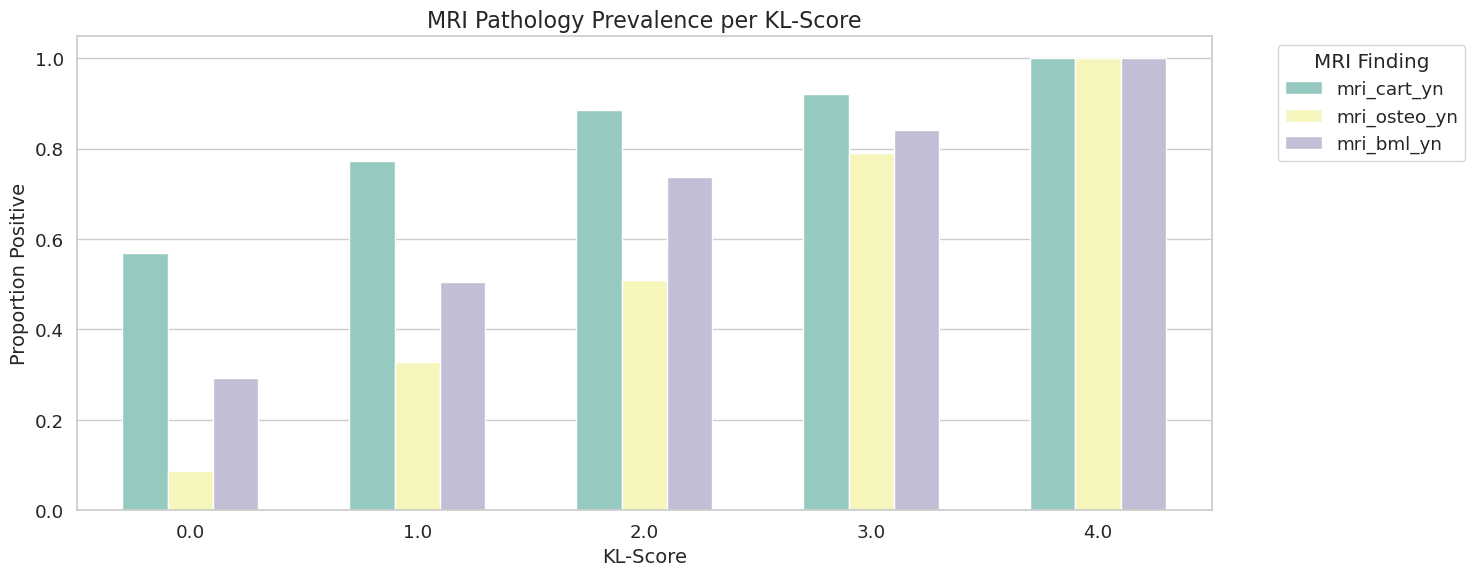

In [109]:
summary = dfc2.groupby('KL-Score')[['mri_cart_yn', 'mri_osteo_yn', 'mri_bml_yn']].mean()
summary_long = summary.reset_index().melt(
    id_vars="KL-Score",
    value_vars=["mri_cart_yn", "mri_osteo_yn", "mri_bml_yn"],
    var_name="MRI_feature",
    value_name="proportion_positive"
)
sns.set_theme(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(15, 6))

sns.barplot(
    data=summary_long,
    x="KL-Score",
    y="proportion_positive",
    hue="MRI_feature",
    palette="Set3"
    , width=0.6
)

plt.xlabel("KL-Score", fontsize=14)
plt.ylabel("Proportion Positive", fontsize=14)
plt.title("MRI Pathology Prevalence per KL-Score", fontsize=16)
plt.legend(
    title="MRI Finding",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)
plt.tight_layout()
plt.show()

# Correlation

In [110]:
from scipy.stats import kruskal

def kruskal_wallis(df, feature, cluster_col = 'cluster_label'):
    groups = [df.loc[df[cluster_col]==cluster, feature] for cluster in df[cluster_col].unique()]
    stat, p = kruskal(*groups)
    return stat, p

## Correlation with KL-Score and Pain

### Kruscal Wallis

In [111]:
columns_corr = [  
 'pain', 'age',
       'ce_bmi', 'ce_fm'
       ] 

for feature in columns_corr:
    for c in dfc2["cluster_label"].unique():
        print(f"NaN values: {dfc2[feature].isna().sum()}")
        vals = dfc2.loc[dfc2["cluster_label"]==c, feature].dropna()
        print(f"For Feature {feature}")
        print(f"Cluster {c}: n={len(vals)}, unique={vals.nunique()}, min={vals.min()}, max={vals.max()}")
    print()


NaN values: 73
For Feature pain
Cluster 0.0: n=312, unique=6, min=0.0, max=9.0
NaN values: 73
For Feature pain
Cluster nan: n=0, unique=0, min=nan, max=nan
NaN values: 73
For Feature pain
Cluster 4.0: n=26, unique=5, min=0.0, max=4.0
NaN values: 73
For Feature pain
Cluster 1.0: n=20, unique=8, min=0.0, max=8.0
NaN values: 73
For Feature pain
Cluster 3.0: n=2, unique=2, min=4.0, max=6.0
NaN values: 73
For Feature pain
Cluster 2.0: n=3, unique=3, min=0.0, max=3.0
NaN values: 73
For Feature pain
Cluster -1.0: n=3, unique=3, min=0.0, max=4.0

NaN values: 73
For Feature age
Cluster 0.0: n=312, unique=33, min=36.0, max=74.0
NaN values: 73
For Feature age
Cluster nan: n=0, unique=0, min=nan, max=nan
NaN values: 73
For Feature age
Cluster 4.0: n=26, unique=11, min=40.0, max=74.0
NaN values: 73
For Feature age
Cluster 1.0: n=20, unique=10, min=48.0, max=75.0
NaN values: 73
For Feature age
Cluster 3.0: n=2, unique=1, min=70.0, max=70.0
NaN values: 73
For Feature age
Cluster 2.0: n=3, unique=2, m

,feature,H-statistic,p-value
0,pain,135.954595,1.295066e-27
1,age,52.640021,3.987176e-10
2,ce_bmi,36.848360,6.423664e-07
3,ce_fm,8.119019,1.497971e-01


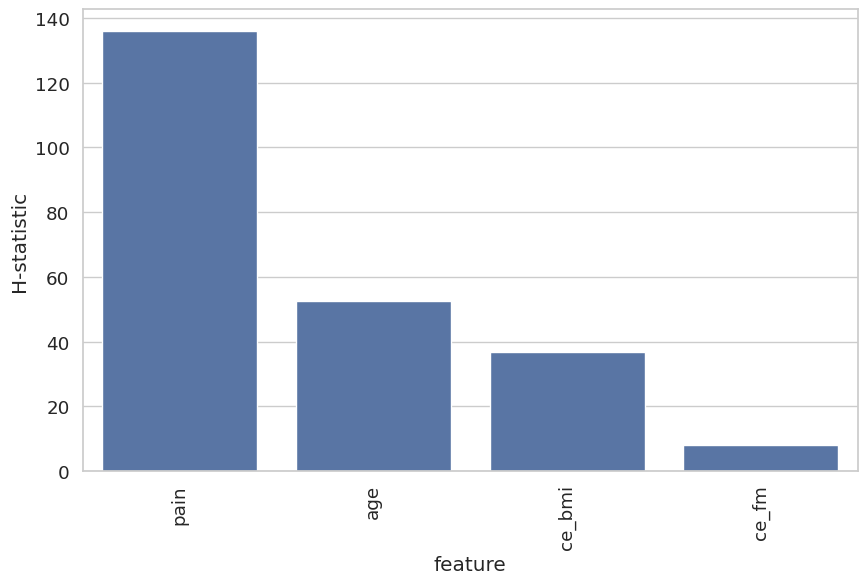

In [112]:
results = []
for feature in columns_corr:
       dfc2_wonan = dfc2.dropna(subset=[feature])
       stat, p = kruskal_wallis(dfc2_wonan, feature, cluster_col = 'cluster_label')
       # print(f"Kruskal-Wallis test for {feature}: H-statistic = {stat:.3f}, p-value = {p:.3e}")
       results.append({'feature': feature, 'H-statistic': stat, 'p-value': p})

results_df = pd.DataFrame(results)
# results_df = results_df.sort_values('p-value')

display(results_df.sort_values('p-value').head())
results_df.to_csv(os.path.join(filepath, f"kruskal_wallis_results_{run}.csv"), index=False)

results_df[results_df['p-value'] >= 0.05]
plt.figure(figsize=(10, 6))
sns.barplot(data = results_df, x='feature', y='H-statistic')
plt.xticks(rotation=90)
plt.show()

Kruskal-Wallis analysis for feature: pain
Kruskal–Wallis H-statistic: 135.955
p-value: 0.0000
Post-hoc Dunn's test results:
Combined p-value (Stouffer's method): 1.0000


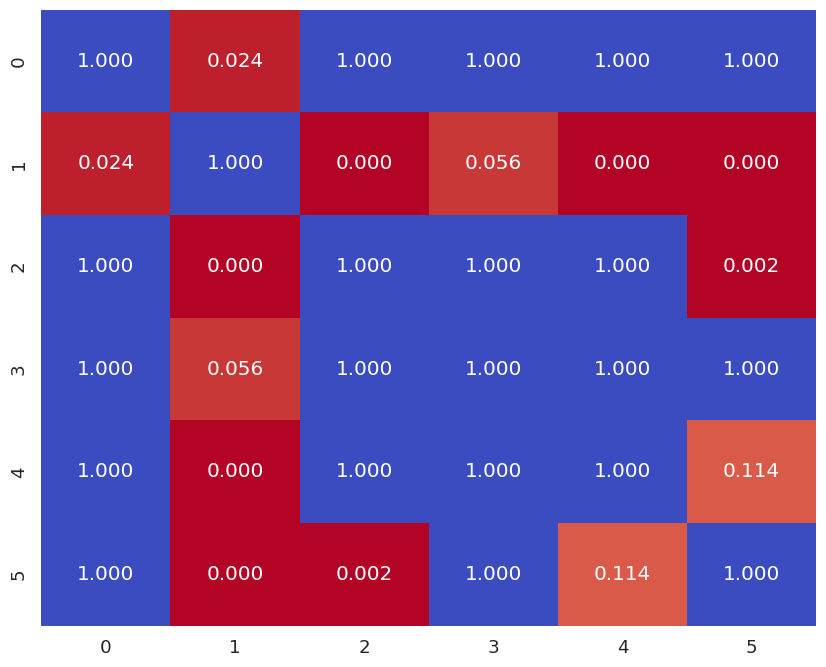

Post-hoc Conover's test results:
Combined p-value (Stouffer's method): 1.0000


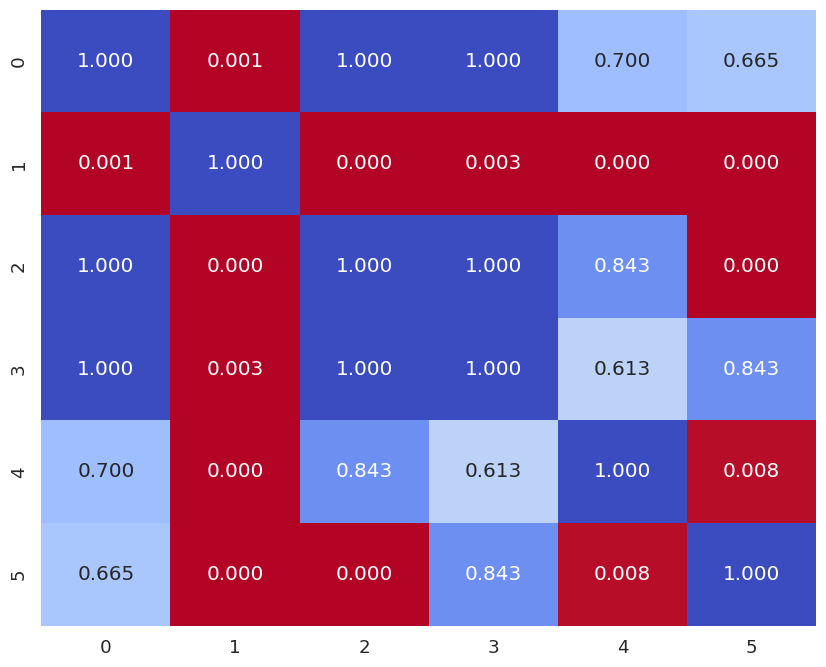

Kruskal-Wallis analysis for feature: age
Kruskal–Wallis H-statistic: 52.640
p-value: 0.0000
Post-hoc Dunn's test results:
Combined p-value (Stouffer's method): 1.0000


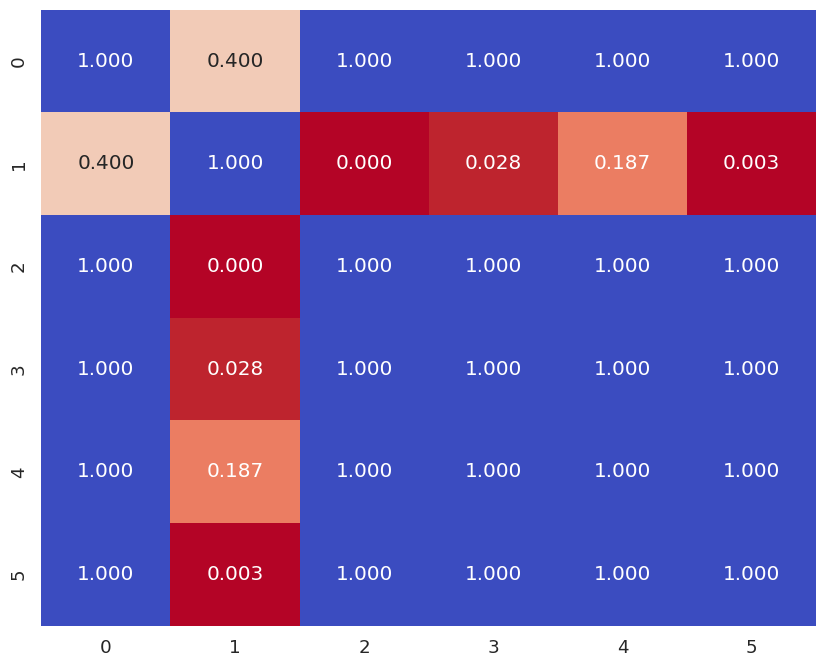

Post-hoc Conover's test results:
Combined p-value (Stouffer's method): 1.0000


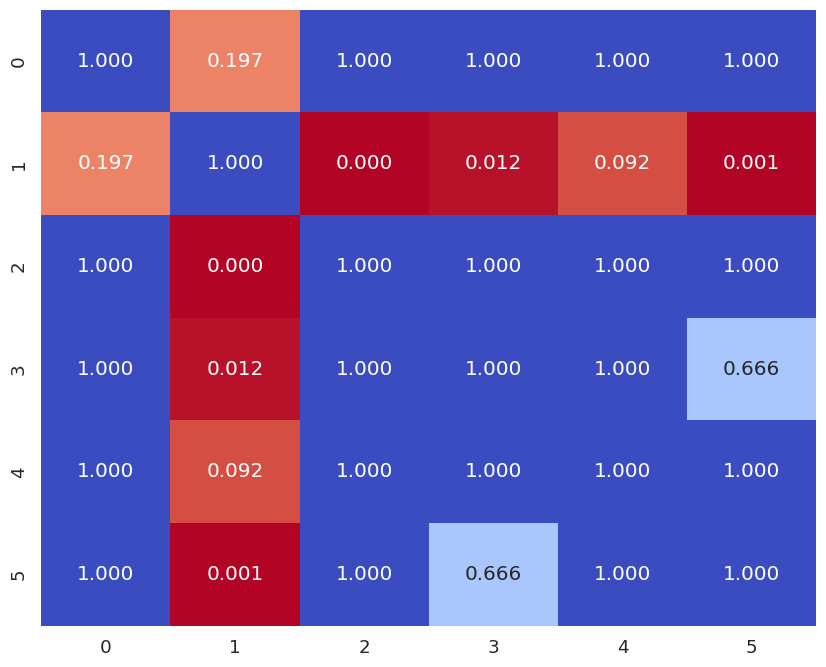

Kruskal-Wallis analysis for feature: ce_bmi
Kruskal–Wallis H-statistic: 36.848
p-value: 0.0000
Post-hoc Dunn's test results:
Combined p-value (Stouffer's method): 1.0000


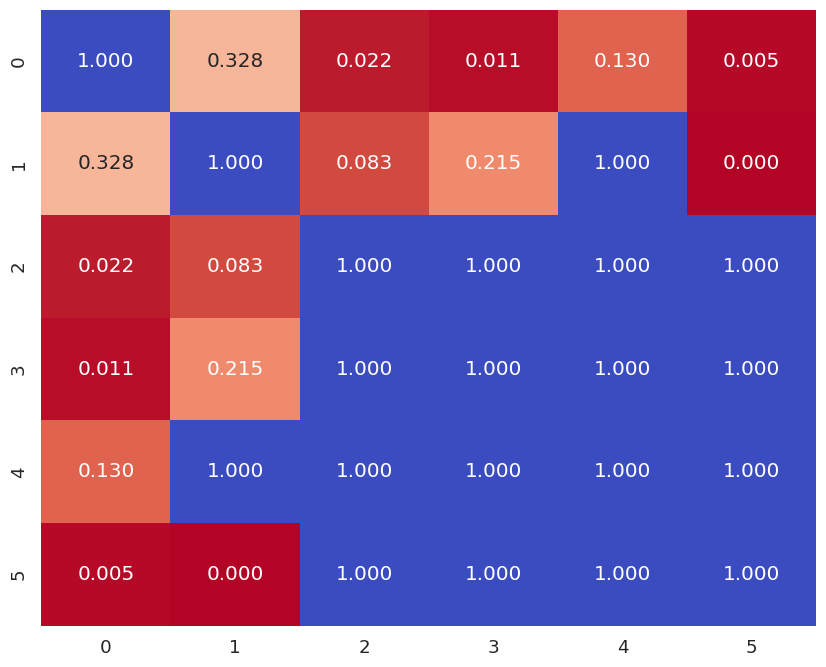

Post-hoc Conover's test results:
Combined p-value (Stouffer's method): 1.0000


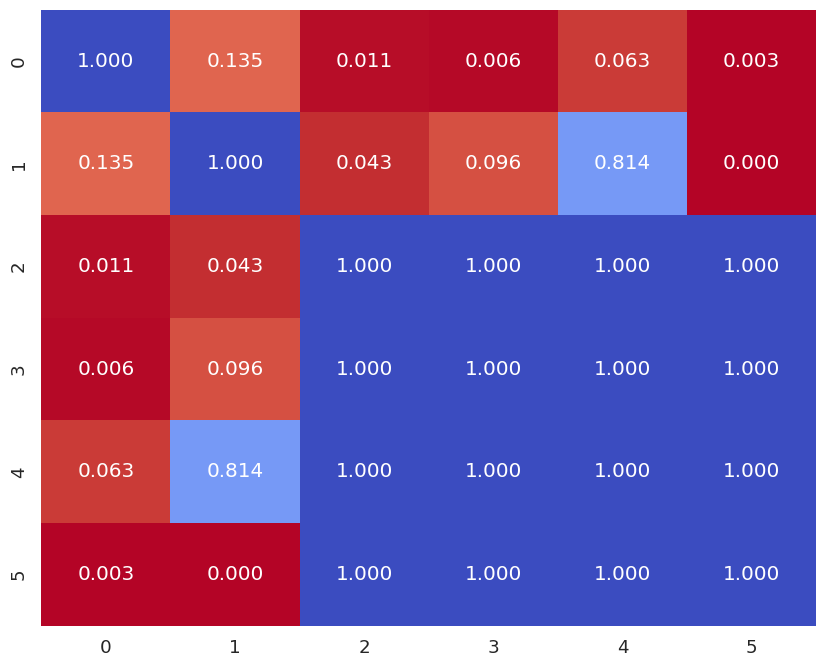

Kruskal-Wallis analysis for feature: ce_fm
Kruskal–Wallis H-statistic: 8.119
p-value: 0.1498


In [113]:
for i in range(len(columns_corr)):
    dfc_wonan = dfc2.copy()
    dfc_wonan = dfc_wonan.dropna(subset=[columns_corr[i]])
    print(f"Kruskal-Wallis analysis for feature: {columns_corr[i]}")
    kruskal_wallis_analysis(dfc_wonan, columns_corr[i], cluster_col='cluster_label')

,feature,H-statistic,p-value
1,mri_osteo_yn,41.282302,8.227901e-08
2,mri_bml_yn,28.178360,3.358996e-05
0,mri_cart_yn,9.831093,8.016507e-02


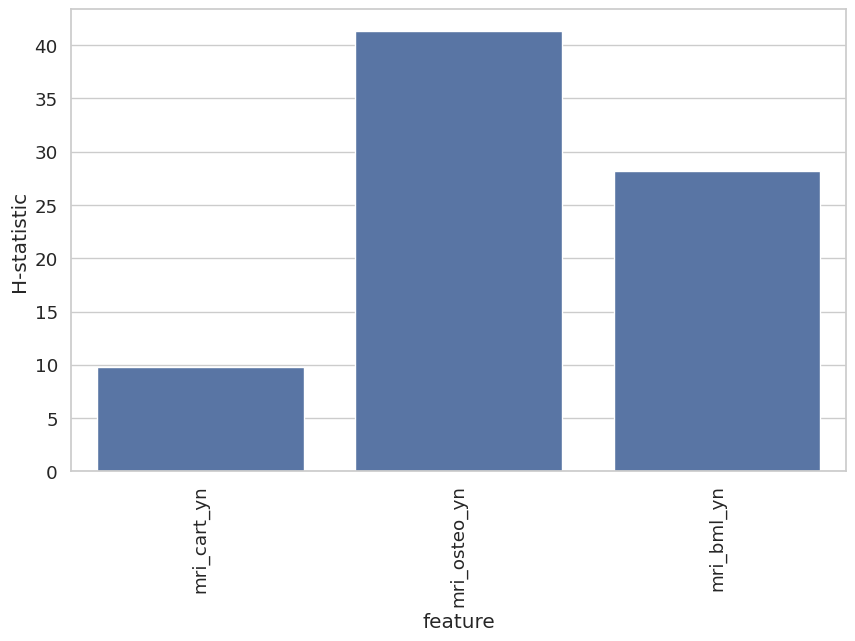

366 samples after dropping NaNs for mri_cart_yn
Kruskal–Wallis H-statistic: 9.831
p-value: 0.0802
366 samples after dropping NaNs for mri_osteo_yn
Kruskal–Wallis H-statistic: 41.282
p-value: 0.0000
Post-hoc Dunn's test results:
Combined p-value (Stouffer's method): 1.0000


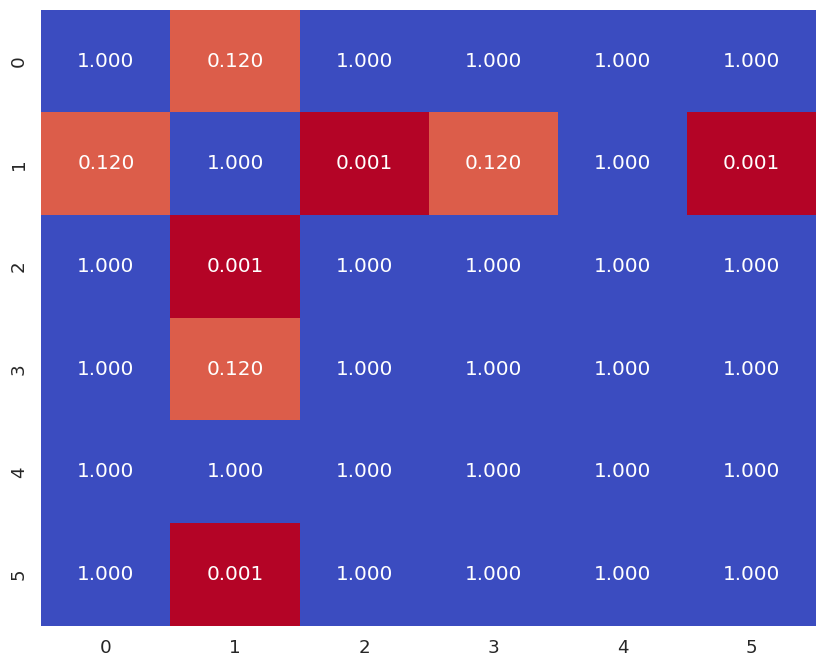

Post-hoc Conover's test results:
Combined p-value (Stouffer's method): 1.0000


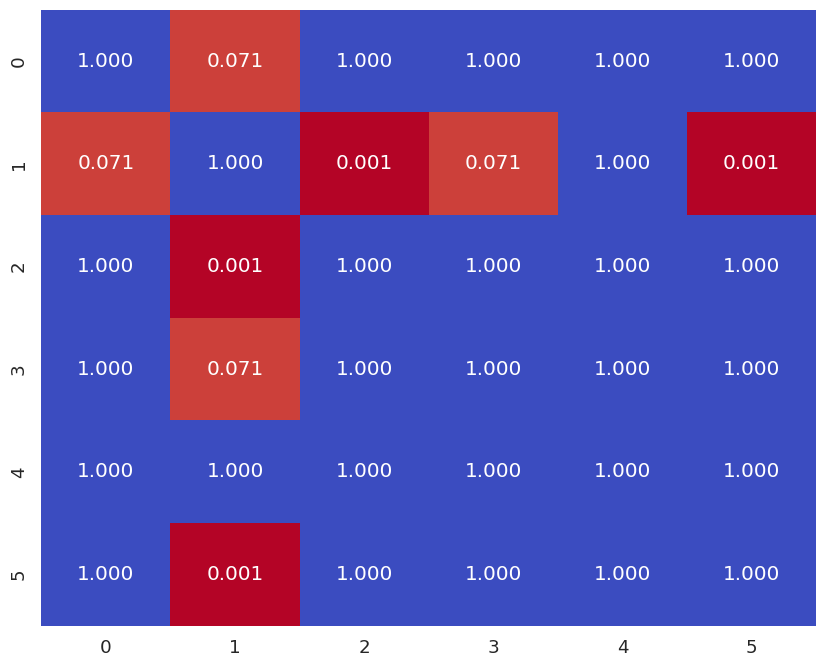

366 samples after dropping NaNs for mri_bml_yn
Kruskal–Wallis H-statistic: 28.178
p-value: 0.0000
Post-hoc Dunn's test results:
Combined p-value (Stouffer's method): 1.0000


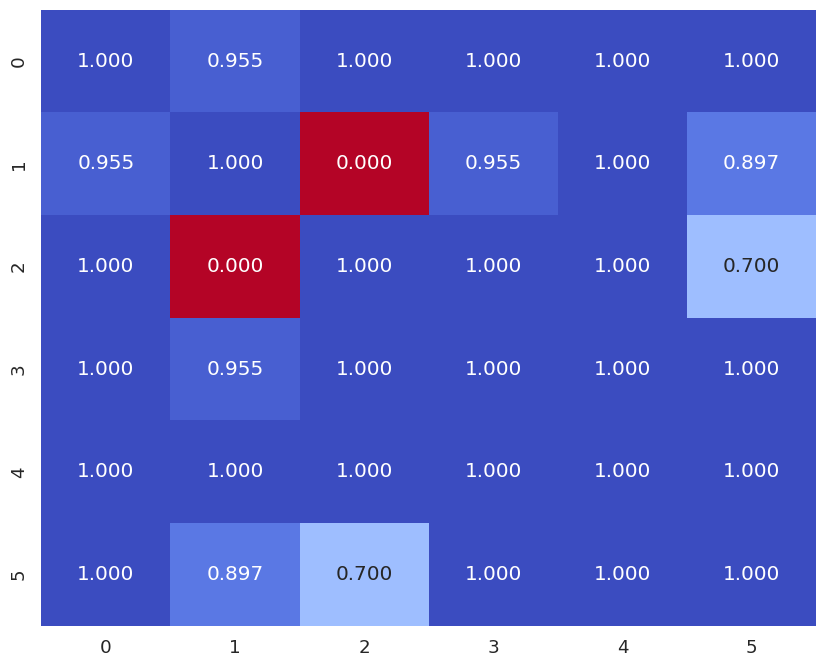

Post-hoc Conover's test results:
Combined p-value (Stouffer's method): 1.0000


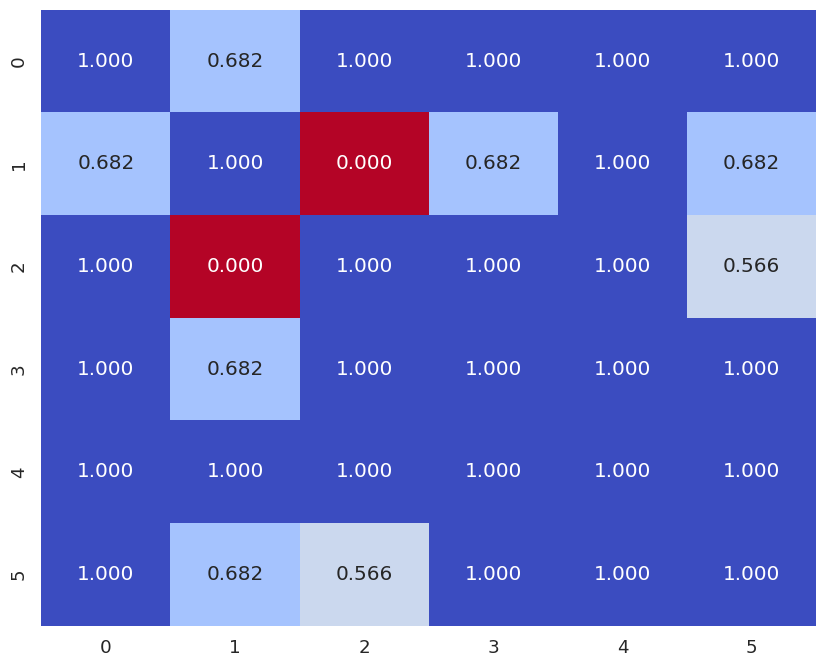

In [114]:
mri_col = ['mri_cart_yn', 'mri_osteo_yn', 'mri_bml_yn']

results = []
for feature in mri_col:
       dfc2_wonan = dfc2.dropna(subset=[feature, 'cluster_label'])
       stat, p = kruskal_wallis(dfc2_wonan, feature, cluster_col = 'cluster_label')
       # print(f"Kruskal-Wallis test for {feature}: H-statistic = {stat:.3f}, p-value = {p:.3e}")
       results.append({'feature': feature, 'H-statistic': stat, 'p-value': p})

results_df = pd.DataFrame(results)
# results_df = results_df.sort_values('p-value')

display(results_df.sort_values('p-value').head())
results_df.to_csv(os.path.join(filepath, f"kruskal_wallis_results_{run}.csv"), index=False)

results_df[results_df['p-value'] >= 0.05]
plt.figure(figsize=(10, 6))
sns.barplot(data = results_df, x='feature', y='H-statistic')
plt.xticks(rotation=90)
plt.show()

for col in mri_col:
    dfc_wonan = dfc2.copy()
    dfc_wonan = dfc_wonan.dropna(subset=[col, 'cluster_label'])
    print(len(dfc_wonan), "samples after dropping NaNs for", col)
    kruskal_wallis_analysis(dfc_wonan, col, cluster_col='cluster_label')

### Plots

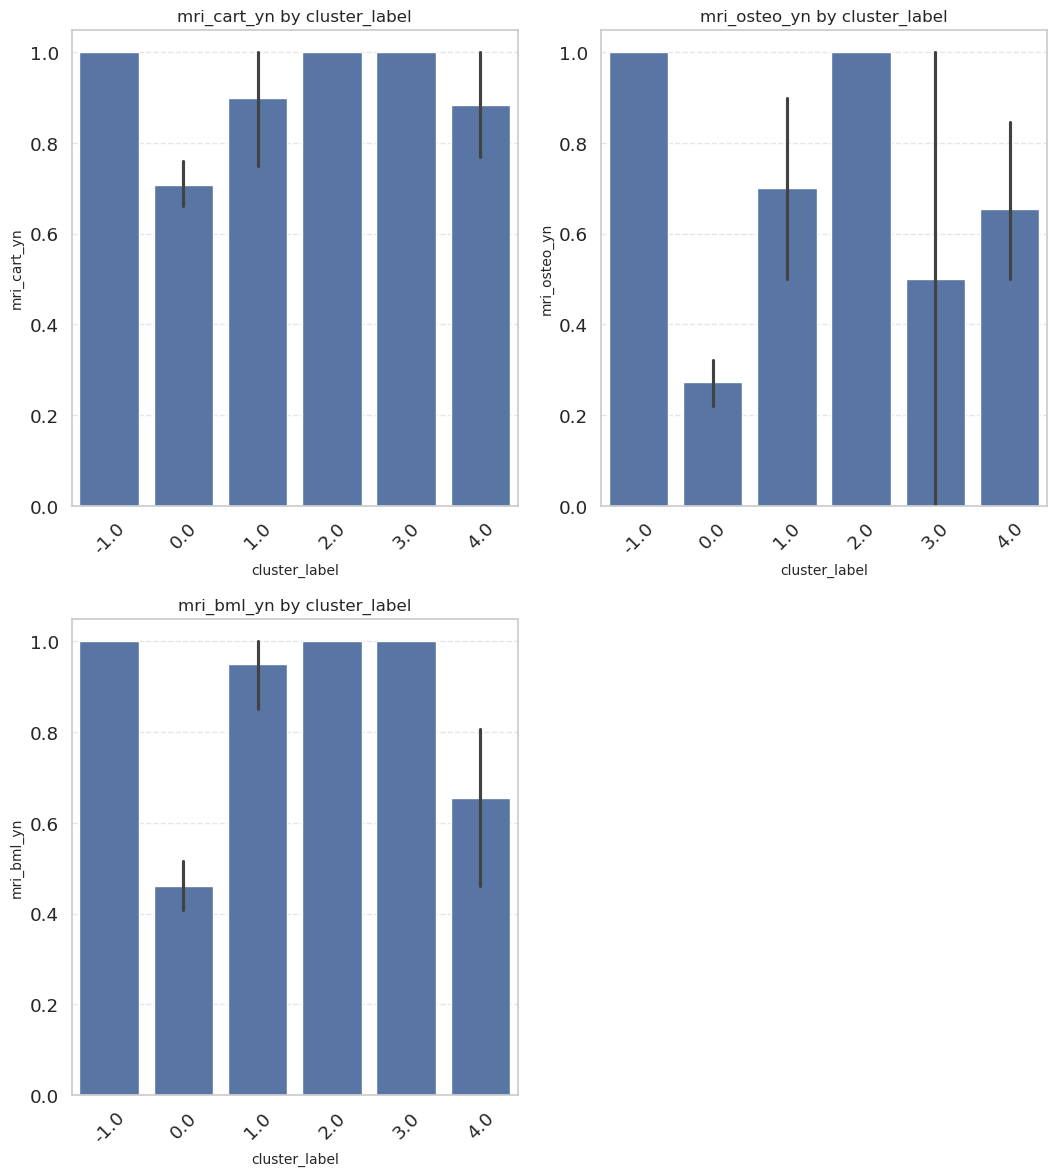

In [115]:
columns_corr =  ['mri_cart_yn', 'mri_osteo_yn', 'mri_bml_yn'] 
barplots(dfc2, y_list=columns_corr, x='cluster_label', hue=None, figsize = (6, 6), savepath=save_path)

# Majority Vote

In [116]:
def majority_vote(df, cluster_col, feature_col):
    clusters = df[cluster_col].unique()
    clusters.sort()

    results = pd.DataFrame({cluster_col: clusters})

    for feature in feature_col:
        majority_vote = df.groupby(cluster_col)[feature].agg(lambda x: list(x.mode()))
        majority_vote = pd.DataFrame(majority_vote).reset_index()
        majority_vote = majority_vote.rename(columns={feature: f'MV_{feature}'})
        results = results.merge(majority_vote, on = cluster_col, how = 'left')

    return results.dropna(axis=0, how='all')

def handle_modes(x, id_):
    if len(x) == 1:
        try:
            return float(x[0])
        except Exception as e:
            print(f"Conversion error for id={id_}: {e}")
            return None
    else:
        print(f"Tie detected for id={id_}: {x}")
        return None  
    
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score
def get_metrics(df, feature):
    y_true = df[feature]
    y_pred = df[f'MV_{feature}']

    print(f'For Feature {feature}:')
    precision=precision_score(y_true, y_pred, average='macro')
    print("Precision:", precision)
    recall = recall_score(y_true, y_pred, average='macro')
    print("Recall:", recall)
    f1 = f1_score(y_true, y_pred, average='macro')
    print("F1 Score:", f1)
    # if len(np.unique(y_true))>2:
    #     print("ROC_AUC:", roc_auc_score(y_true, y_pred, multi_class='ovo'))
    # else:
    #     print("ROC_AUC:", roc_auc_score(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n")
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.savefig(os.path.join(filepath, f'{feature}_confusionmatrix.png'))
    plt.show()

    return precision, recall, f1

def get_metrics_percluster(df, feature, cluster_col = 'cluster_label', normalized=False):
    print(f'For Feature {feature}:')
    clusters = np.unique(df[cluster_col])

    for c in clusters:
        mask = df[cluster_col] ==c

        if mask.sum()<2:
            print(f'Skipping cluster {c}: only {mask.sum()} samples')
            continue
        y_pred = df.loc[mask, f'MV_{feature}']
        y_true = df.loc[mask, feature]

        cm = confusion_matrix(
                y_true,
                y_pred,
                normalize='true' if normalized else None
            )
        
        labels = sorted(np.unique(y_true.tolist() + y_pred.tolist()))
        plt.figure(figsize=(5, 4))
        sns.heatmap(
            cm,
            annot=True,
            fmt='.2f' if normalized else 'd',
            cmap='YlGnBu',
            cbar=False,
            xticklabels=labels,
            yticklabels=labels
        )
        plt.title(f'Confusion Matrix – Cluster {c} ({mask.sum()} samples)')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.show()

## Plot Distribution per cluster first

<Figure size 1000x600 with 0 Axes>

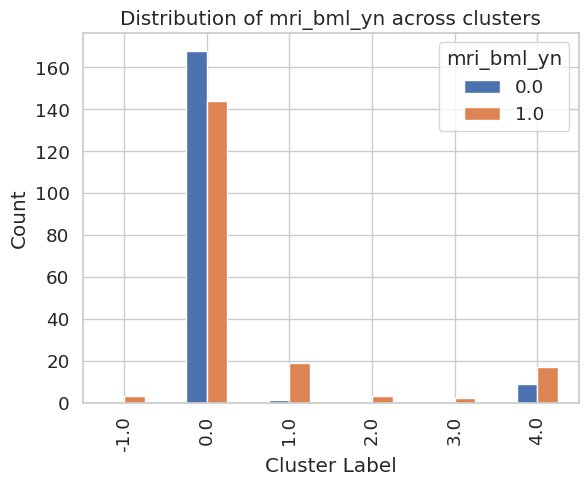

<Figure size 1000x600 with 0 Axes>

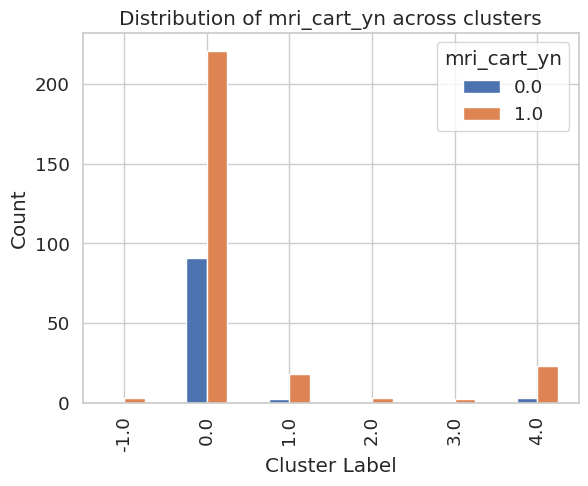

<Figure size 1000x600 with 0 Axes>

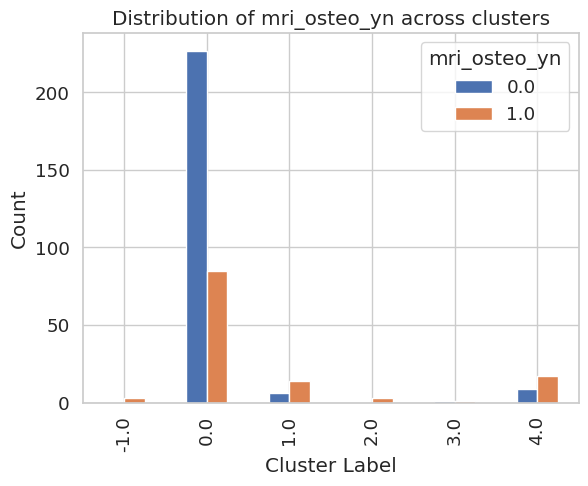

<Figure size 1000x600 with 0 Axes>

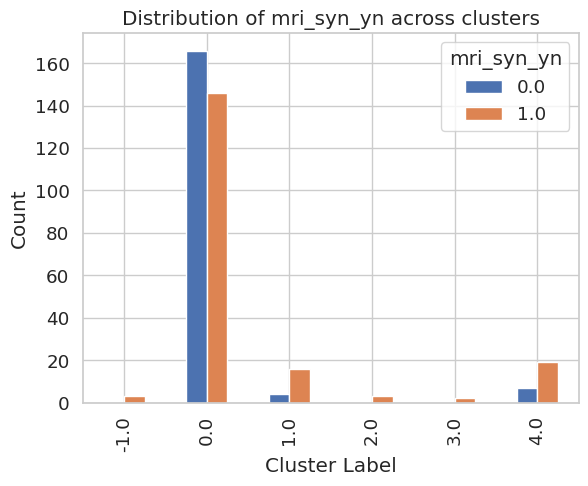

<Figure size 1000x600 with 0 Axes>

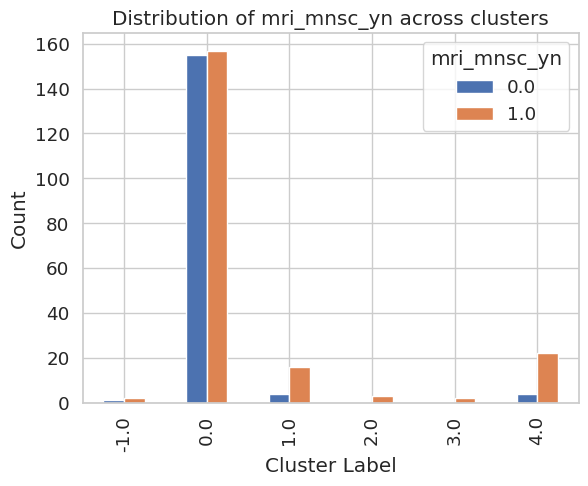

<Figure size 1000x600 with 0 Axes>

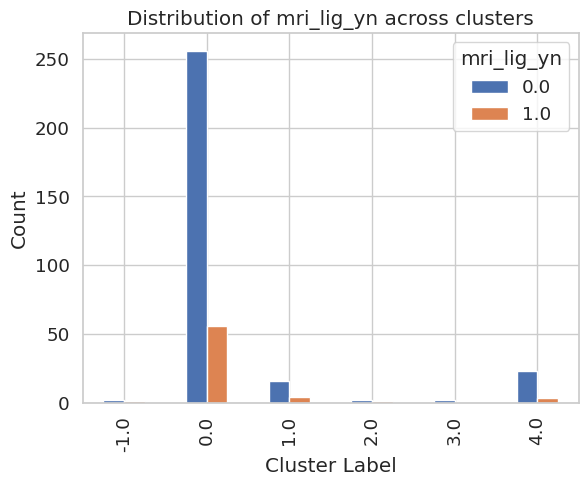

In [117]:
feature_col = ['mri_bml_yn', 'mri_cart_yn', 'mri_osteo_yn', 'mri_syn_yn', 'mri_mnsc_yn', 'mri_lig_yn']

for feature in feature_col:
    clusters = dfc2['cluster_label'].unique()
    clusters.sort()

    counts = dfc2.groupby(['cluster_label', feature]).size().unstack(fill_value=0)

    plt.figure(figsize=(10, 6))
    counts.plot(kind='bar', stacked=False)
    plt.title(f'Distribution of {feature} across clusters')
    plt.xlabel('Cluster Label')
    plt.ylabel('Count')
    plt.show()

## Majority Vote official

In [118]:
maj_vote = majority_vote(dfc2, 'cluster_label', feature_col)

In [119]:
for feature in feature_col:
    col_name = f'MV_{feature}'
    maj_vote[col_name] = [
        handle_modes(row[col_name], row['cluster_label'])
        for _, row in maj_vote.iterrows()
    ]

Tie detected for id=3.0: [0.0, 1.0]


In [120]:
display(maj_vote)

,cluster_label,MV_mri_bml_yn,MV_mri_cart_yn,MV_mri_osteo_yn,MV_mri_syn_yn,MV_mri_mnsc_yn,MV_mri_lig_yn
0,-1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,2.0,1.0,1.0,1.0,1.0,1.0,0.0
4,3.0,1.0,1.0,NaN,1.0,1.0,0.0
5,4.0,1.0,1.0,1.0,1.0,1.0,0.0


In [121]:
maj_vote.to_csv(os.path.join(filepath, 'maj_vote_eval.csv'), index=False)

## Calculate Precision, Recall, F1-Score etc.

In [122]:
dfc3 = dfc2.merge(maj_vote, how = 'left', on= 'cluster_label')
dfc3 = dfc3.dropna(subset=['cluster_label'])

In [123]:
try:
    feature_col.remove('KL-Score')
except Exception as e:
    print(e)
    pass
   

list.remove(x): x not in list


For Feature mri_bml_yn:
Precision: 0.6766381766381766
Recall: 0.5889313889552952
F1 Score: 0.5246753246753246
Confusion Matrix:



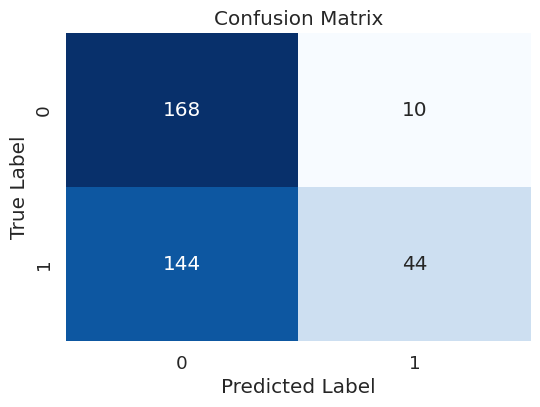

For Feature mri_cart_yn:
Precision: 0.36885245901639346
Recall: 0.5
F1 Score: 0.42452830188679247
Confusion Matrix:



/home/czuppinger/miniconda3/envs/mtenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


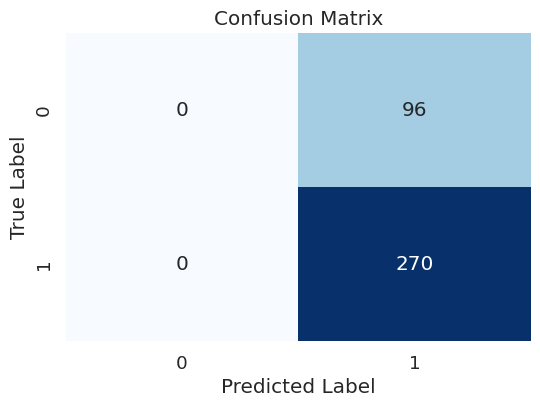

For Feature mri_osteo_yn:


/home/czuppinger/miniconda3/envs/mtenv/lib/python3.12/site-packages/sklearn/externals/array_api_compat/numpy/_aliases.py:127: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype=dtype, copy=copy)


ValueError: Input y_pred contains NaN.

In [124]:
metrics = pd.DataFrame()

for feature in feature_col:
    precision, recall, f1 = get_metrics(dfc3, feature)
    results = {'feature': feature,
               'precision': precision,
               'recall': recall,
               'f1_score': f1}
    results = pd.DataFrame([results])
    metrics = pd.concat([metrics, results])

For Feature mri_bml_yn:


/home/czuppinger/miniconda3/envs/mtenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


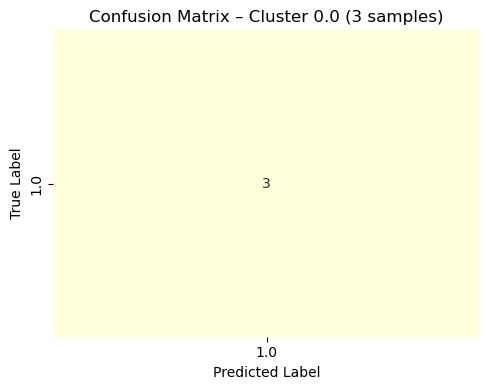

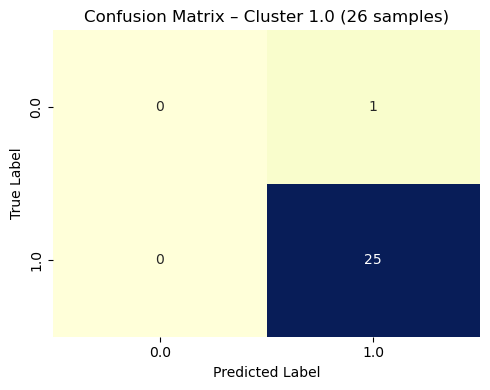

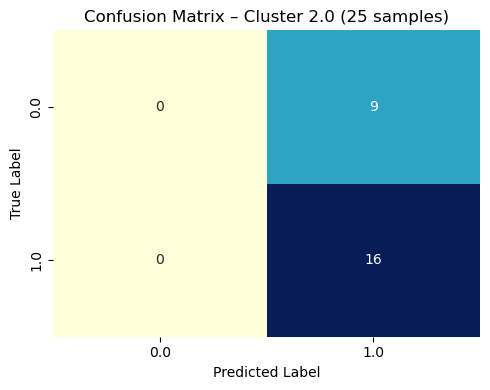

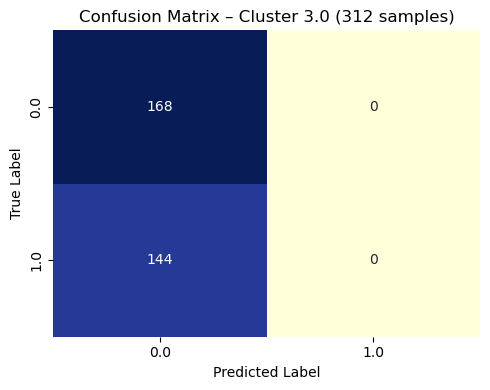

For Feature mri_cart_yn:


/home/czuppinger/miniconda3/envs/mtenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


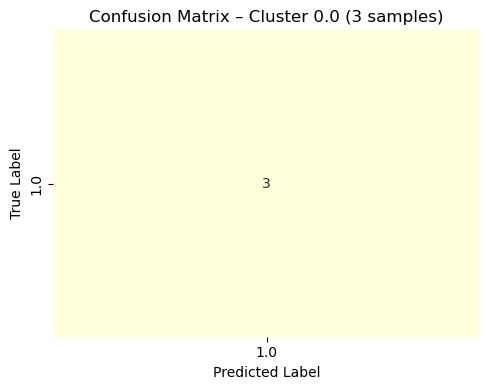

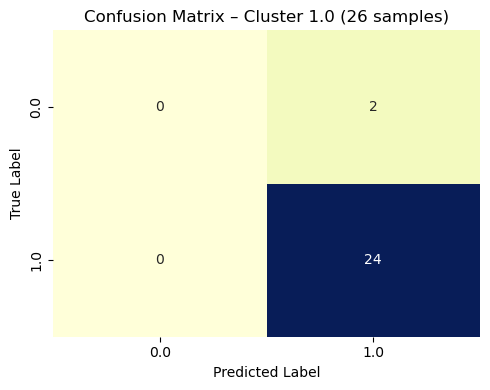

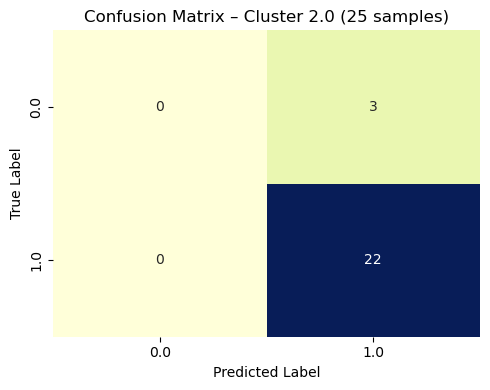

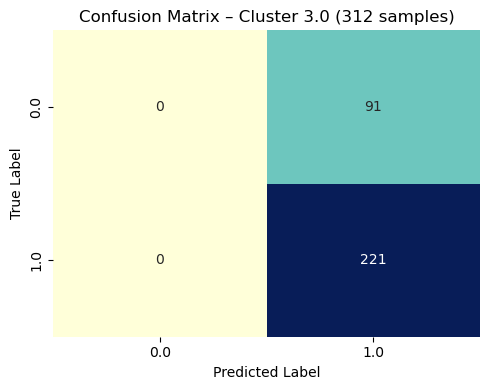

For Feature mri_osteo_yn:


/home/czuppinger/miniconda3/envs/mtenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


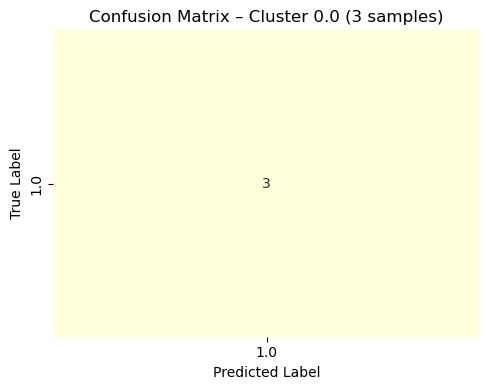

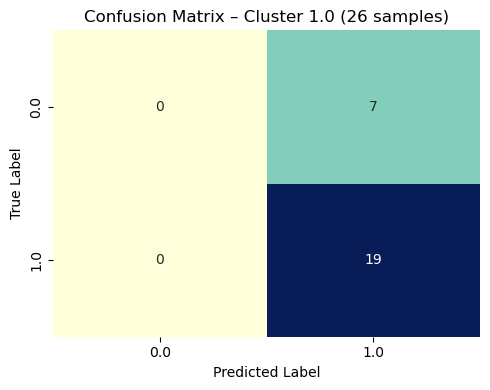

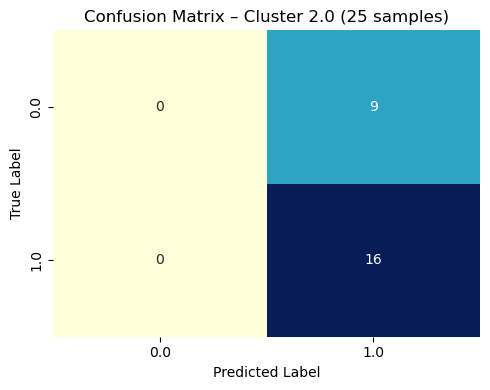

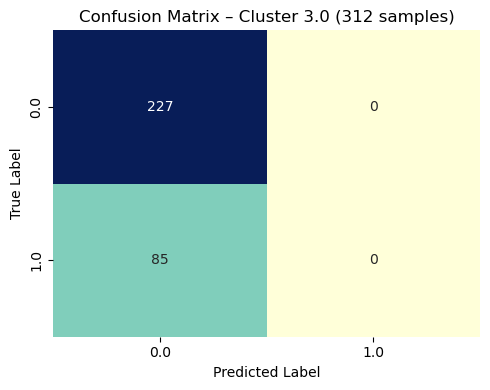

For Feature mri_syn_yn:


/home/czuppinger/miniconda3/envs/mtenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


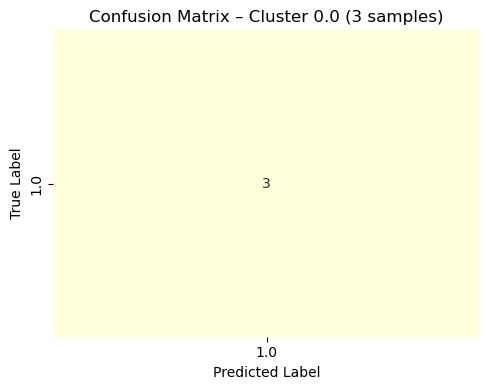

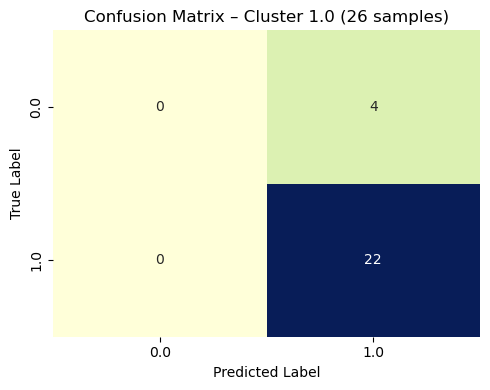

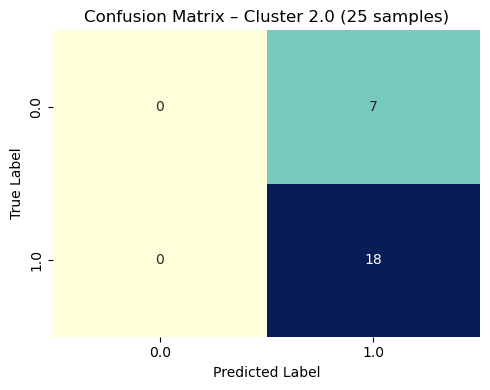

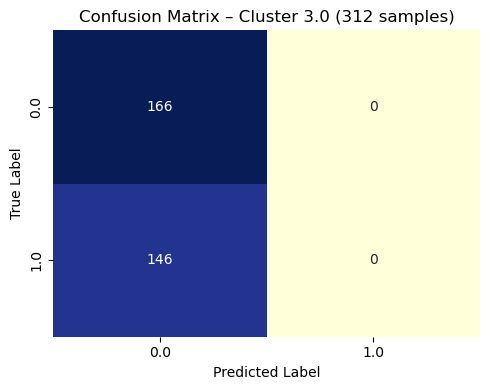

For Feature mri_mnsc_yn:


/home/czuppinger/miniconda3/envs/mtenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


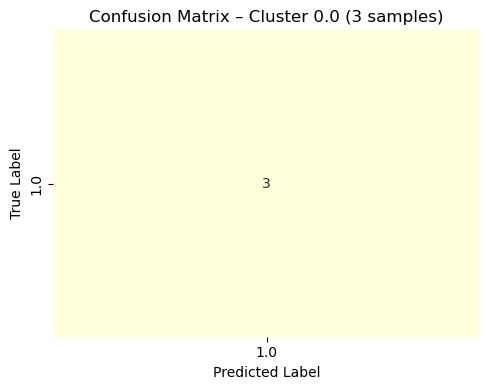

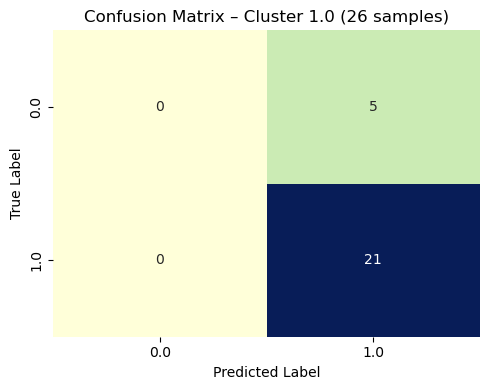

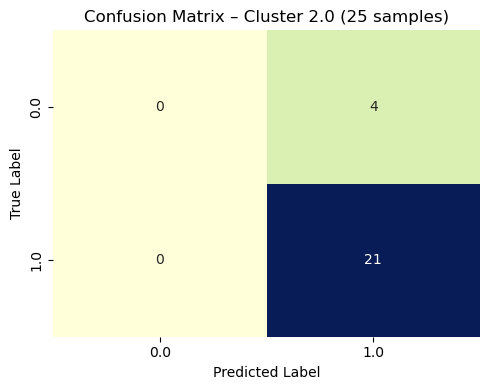

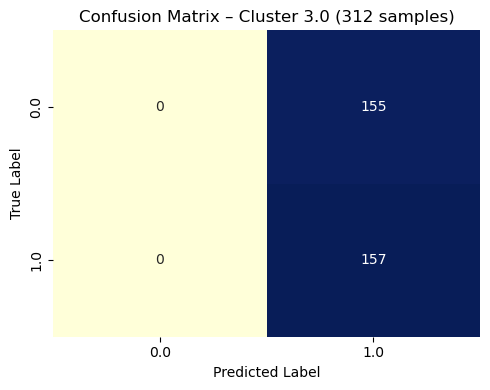

For Feature mri_lig_yn:


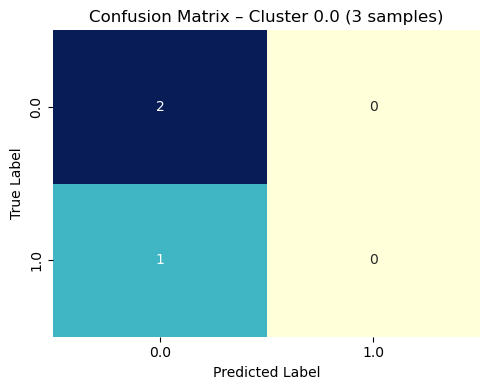

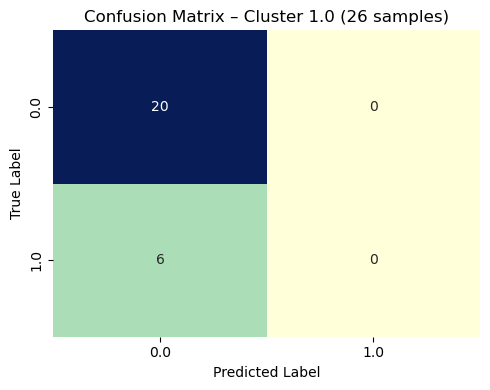

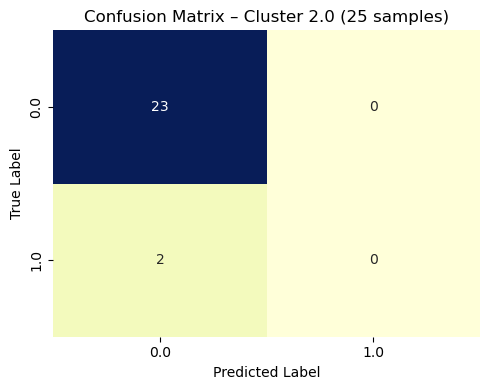

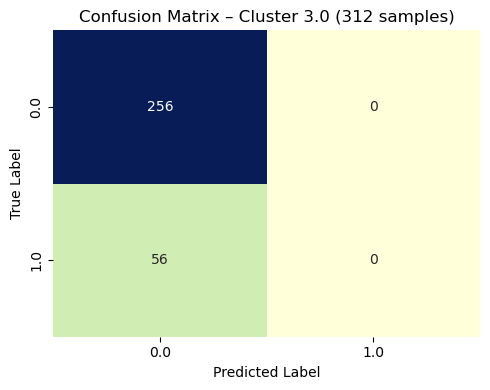

In [ ]:
for feature in feature_col:
    get_metrics_percluster(dfc3, feature, normalized=False)